# Characterize predicted mutations

This notebook processes the ranked mutations in `paper/mutations.tsv` and generates output plots for examining mutational enrichment.

In [1]:
# imports
library(data.table)
library(tidyverse)
library(testit)
library(pheatmap)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



In [2]:
# Set graphics
options(repr.plot.width=10, repr.plot.height=10)
output_plot_dir <- 'paper/mutation_scoring/'
plot_dpi = 300

In [3]:
# Read input data
res_mutations <- fread('paper/mutations.tsv')

In [4]:
# Helper functions
strpart <- function(x, split, n, fixed=FALSE) {
    sapply(strsplit(as.character(x),split,fixed=fixed),'[',n)
}

matrix_to_long_df <- function(matrix) {
    rn <- rownames(matrix)
    cn <- colnames(matrix)
    df <- as.data.frame(matrix)
    colnames(df) <- cn
    df$rownames <- rn
    pivot_longer(df, !rownames, names_to = "colnames")
}

## Get summary of mutations at the top of the list

In [5]:
get_mutation_summary <- function(mutations, n_mutations = NULL, return_matrix = TRUE, select_gene = NULL) {
    aa_chars = sort(c('G','A','L','M','F','W','K','Q','E','S','P','V','I','C','Y','H','R','N','D','T'))
    
    if (!is.null(n_mutations)) {
        mutations[1:n_mutations,] %>% pull('mutation') -> mutation_strings
    } else {
        mutations %>% pull('mutation') -> mutation_strings
    }
    
    # Extract mutation information
    gene <- strpart(mutation_strings, ':', 1)
    aa_change <- strpart(mutation_strings, ':', 2)
    aa_from <- substr(aa_change,1,1)
    position <- substr(aa_change,2,nchar(aa_change)-1)
    aa_to <- substr(aa_change,nchar(aa_change),nchar(aa_change))
    mutation_data_parse <- data.frame(
        gene,
        aa_from,
        position,
        aa_to
    )
    
    # Subset to specific gene
    if (!is.null(select_gene)) {
        mutation_data_parse <- mutation_data_parse[gene == select_gene,]
    }
    
    # Filter to only amino acid changes (otherwise it includes 'e')
    mutation_data_parse %>% 
        filter(aa_from %in% aa_chars) %>%
        filter(aa_to %in% aa_chars) -> mutation_data_parse
    
    # Count mutations
    mutation_data_parse[,c('aa_from','aa_to')] %>% 
        group_by(aa_from, aa_to) %>% summarise(n=n(), .groups="drop") -> summarized_counts
    

    if (return_matrix) {
        # pivot wider
        summarized_counts %>% pivot_wider(
            id_cols = c(aa_from, aa_to),
            names_from = aa_to,
            values_from = n,
            values_fill=0
        ) -> mutation_counts_actual
        
        # Turn to matrix
        rn <- mutation_counts_actual$aa_from
        cn <- colnames(mutation_counts_actual)
        mutation_counts_actual <- (as.matrix(mutation_counts_actual[,-1]))
        rownames(mutation_counts_actual) <- rn
        colnames(mutation_counts_actual) <- cn[-1]

        # Find missing cols and rows
        missing_cols <- setdiff(aa_chars, colnames(mutation_counts_actual))
        missing_rows <- setdiff(aa_chars, rownames(mutation_counts_actual))

        # Add missing cols
        original_cn <- colnames(mutation_counts_actual)
        mutation_counts_actual <- cbind(mutation_counts_actual, 
                                        matrix(0, nrow(mutation_counts_actual), 
                                               length(missing_cols)))
        colnames(mutation_counts_actual) <- c(original_cn, missing_cols)
        # Add missing rows
        original_rn <- rownames(mutation_counts_actual)
        mutation_counts_actual <- rbind(mutation_counts_actual,
                                        matrix(0, length(missing_rows),
                                              ncol(mutation_counts_actual)))
        rownames(mutation_counts_actual) <- c(original_rn, missing_rows)

        # Put in order
        mutation_counts_actual <- mutation_counts_actual[aa_chars,aa_chars]
        
        # Rows -- from
        # Cols -- to
        mutation_counts_actual <- t(mutation_counts_actual)

        return(mutation_counts_actual)
    } else {
        return(summarized_counts)
    }

}

In [6]:
# Mutation type occurences in top 1000 entries
n_mutations <- 1000

In [7]:
# For confirming orientation of output
get_mutation_summary(res_mutations, n_mutations = n_mutations, return_matrix=FALSE) %>% 
    filter(aa_from == 'I' & aa_to == 'T')

aa_from,aa_to,n
<chr>,<chr>,<int>
I,T,17


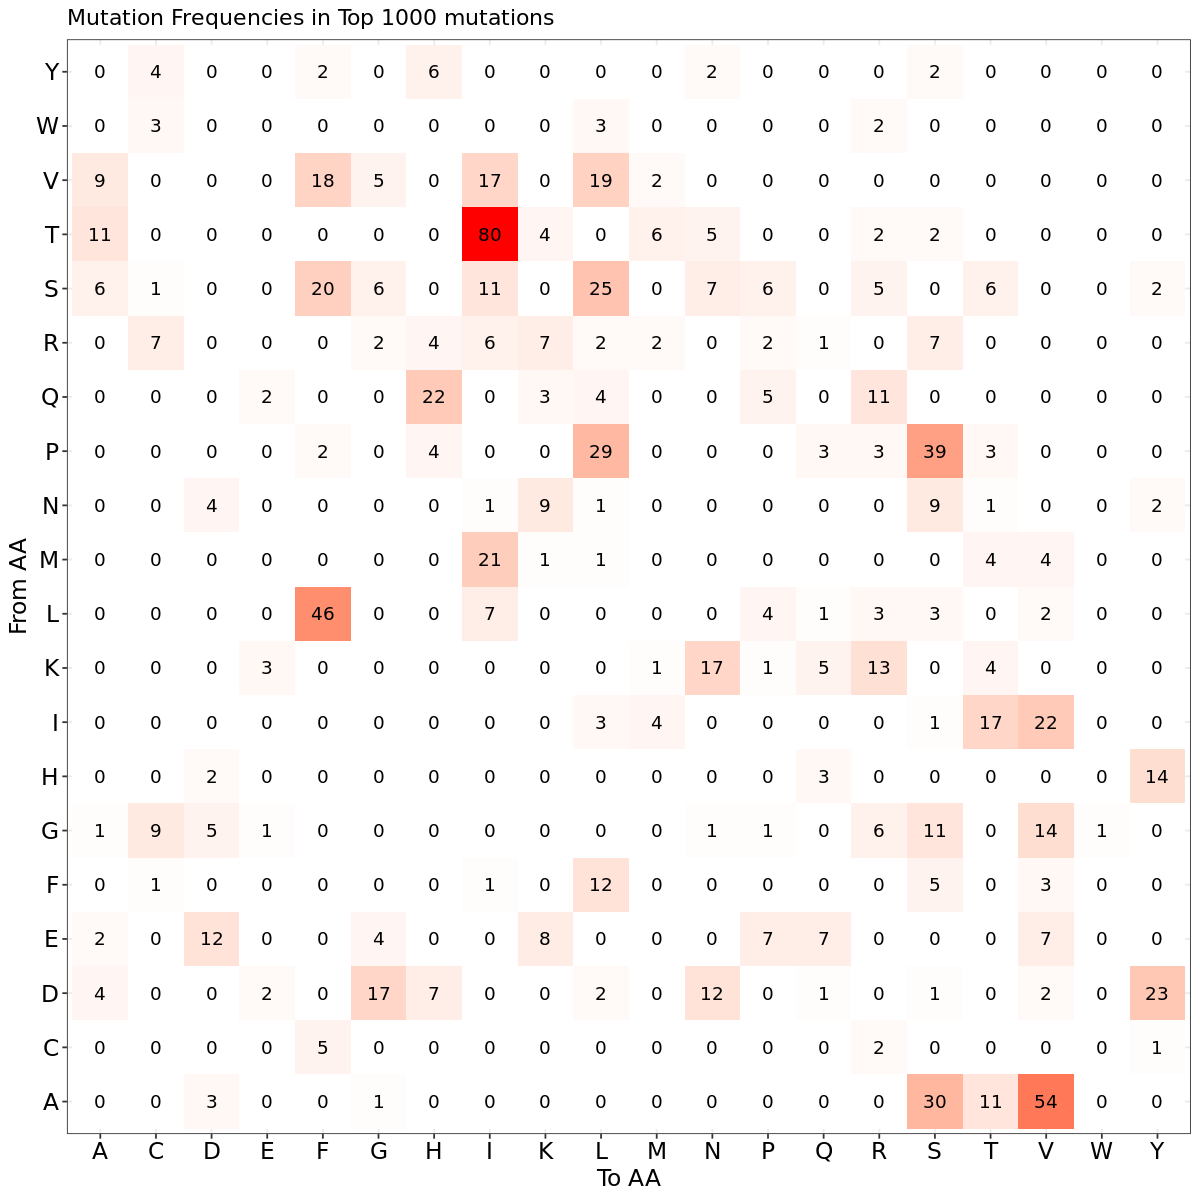

In [8]:
matrix_to_long_df(get_mutation_summary(res_mutations, n_mutations = n_mutations)) %>% 
    ggplot(aes(x=rownames, y=colnames, fill=value)) + 
    geom_tile() +
    theme_bw() +
    theme(axis.text.x = element_text(color='black', size=14), axis.text.y = element_text(color='black', size=14), axis.title.x = element_text(color='black', size=14), axis.title.y = element_text(color='black', size=14),
         legend.position = "none") +
    scale_fill_gradient(low = "white", high = "red") +
    geom_text(aes(label=value)) +
    ggtitle(paste0('Mutation Frequencies in Top ', n_mutations, ' mutations')) +
    scale_x_discrete(name='To AA') +
    scale_y_discrete(name='From AA') -> plot_aa_frequencies

plot_aa_frequencies

In [9]:
ggsave(paste0(output_plot_dir, 'top_substitutions.png'), width=6, height=6, dpi = plot_dpi)

## Test for enrichment of particular mutations

In [10]:
test_mutation_enrichment <- function(res_mutations, n_mutations=1000, symmetric = TRUE, select_gene = NULL) {
    aa_chars = sort(c('G','A','L','M','F','W','K','Q','E','S','P','V','I','C','Y','H','R','N','D','T'))
    
    top_mut <- get_mutation_summary(res_mutations, n_mutations, select_gene = select_gene)
    universe_mut <- get_mutation_summary(res_mutations, NULL, select_gene = select_gene)
    
    pvals <- matrix(0, length(aa_chars), length(aa_chars))
    rownames(pvals) <- colnames(pvals) <- aa_chars
    
    top_total <- sum(top_mut)
    universe_total <- sum(universe_mut)
    
    universe_rate <- universe_mut / universe_total

    for (from_aa in aa_chars) {
        for (to_aa in aa_chars) {
            if (from_aa == to_aa) {
                # Do not test synonymous
                pvals[from_aa, to_aa] <- NA
            } else {
                if (symmetric) {
                    this_mutation_count = top_mut[from_aa, to_aa] + top_mut[to_aa, from_aa] # observed count
                    this_mutation_global_prob = universe_rate[from_aa, to_aa] + universe_rate[to_aa, from_aa] #expected_rate
                } else {
                    this_mutation_count = top_mut[from_aa, to_aa] # observed count
                    this_mutation_global_prob = universe_rate[from_aa, to_aa] # excpected rate
                }
                pvals[from_aa, to_aa] <- dbinom(this_mutation_count, top_total, this_mutation_global_prob)
            }
        }
    }
    
    pvals    
}

In [11]:
# Confirm symmetric output when symmetric comparison
assert(isSymmetric(test_mutation_enrichment(res_mutations, 100, symmetric=TRUE)))

In [12]:
# Look for maximal mutational enrichment while scanning for number of genes considered
summary_fn_min <- function(x) {min(x, na.rm = TRUE)}
summary_fn_mean <- function(x) {mean(x, na.rm = TRUE)}

test_mutation_enrichment_serial <- function(res_mutations, n_start=1, n_end=1000, step=1, symmetric=TRUE, summary_fn=summary_fn_min, select_gene = NULL) {
    xs <- seq(n_start, n_end, step)
    ys <- unlist(lapply(xs, function(x) {
        summary_fn(test_mutation_enrichment(res_mutations,n=x, symmetric=symmetric, select_gene = select_gene))
    }))
    most_sign_pval <- data.frame(n=xs, most_sign_pval= ys)
    most_sign_pval
}

In [13]:
# Look both with synonymous and non-synonymour changes considered
# Get mean and maximal p-value for each
n_end <- 3000

most_sign_pval_sym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10, symmetric = TRUE, summary_fn=summary_fn_min)
most_sign_pval_sym$type <- 'most'
most_sign_pval_sym$sym <- 'symmetric'

most_sign_pval_nonsym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10,symmetric = FALSE, summary_fn=summary_fn_min)
most_sign_pval_nonsym$type <- 'most'
most_sign_pval_nonsym$sym <- 'non-symmetric'

mean_sign_pval_sym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10,symmetric = TRUE, summary_fn=summary_fn_mean)
mean_sign_pval_sym$type <- 'mean'
mean_sign_pval_sym$sym <- 'symmetric'

mean_sign_pval_nonsym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10,symmetric = FALSE, summary_fn=summary_fn_mean)
mean_sign_pval_nonsym$type <- 'mean'
mean_sign_pval_nonsym$sym <- 'non-symmetric'

plot_data <- rbind(most_sign_pval_sym, most_sign_pval_nonsym, mean_sign_pval_sym, mean_sign_pval_nonsym)

In [14]:
# multiple testing corrected p-value for all tests except diagonal
# we can be less stringent in the synonymous case
pval_cutoff <- 0.05 / (20*20-20)

In [15]:
dim(res_mutations)

[1] 2904   11

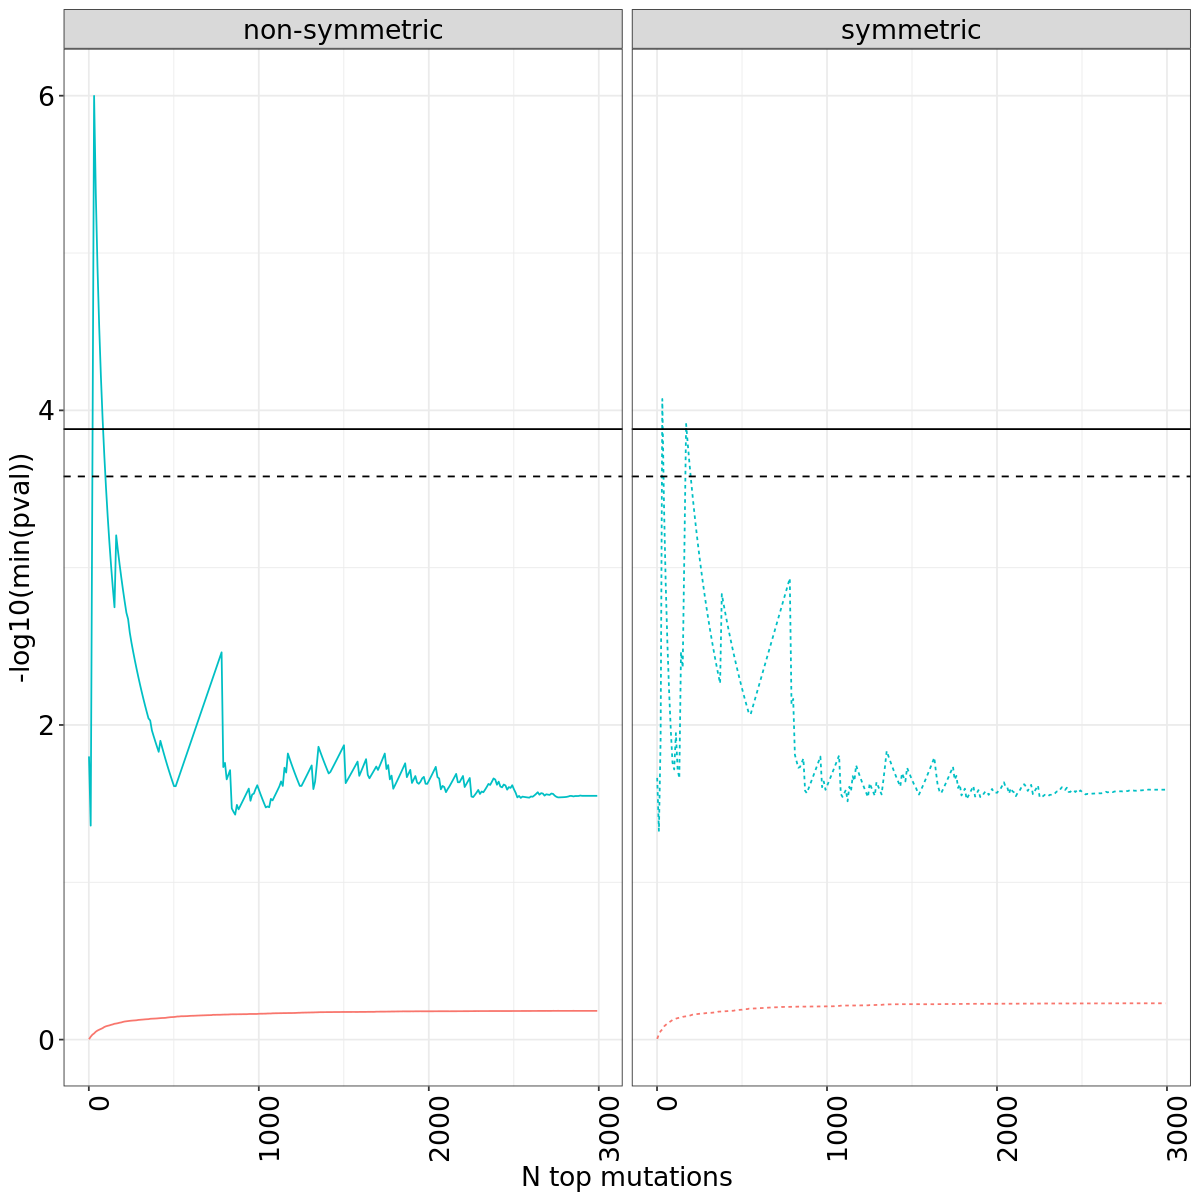

In [39]:
font_size = 16

ggplot(plot_data, aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
    geom_line() +
    geom_hline(yintercept = -log10(pval_cutoff)) + 
    geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
    facet_wrap(~sym) +
    theme_bw() + 
    theme(axis.text.x = element_text(color='black', size=font_size, angle = 90, hjust=1), 
          axis.text.y = element_text(color='black', size=font_size), 
          axis.title.x = element_text(color='black', size=font_size), 
          axis.title.y = element_text(color='black', size=font_size),
          strip.text.x = element_text(color='black', size=font_size),
         legend.position = "none") +
    scale_x_continuous(name="N top mutations") + 
    scale_y_continuous(name="-log10(min(pval))") -> plot_pval_vs_top_genes

plot_pval_vs_top_genes

In [23]:
ggsave(paste0(output_plot_dir, 'pvals_vs_top_genes.png'), width=6, height=6, dpi = plot_dpi)

In [24]:
test_individual_mutation_enrichment_serial <- function(res_mutations, n_start=1, n_end=1000, step=1, symmetric=TRUE, select_gene = NULL) {
    ns <- seq(n_start, n_end, step)
    info <- do.call(rbind, lapply(ns, function(x) {
        df.tmp <- matrix_to_long_df(test_mutation_enrichment(res_mutations,n=x,symmetric=symmetric, select_gene = select_gene))
        df.tmp$n <- x
        df.tmp$aa_change = paste0(df.tmp$rownames,'->', df.tmp$colnames)
        df.tmp$rownames = NULL
        df.tmp$colnames = NULL
        df.tmp
    }))
    info
}

In [25]:
info <- test_individual_mutation_enrichment_serial(res_mutations,1,1000, symmetric=FALSE)

Warning message:
“Removed 20000 row(s) containing missing values (geom_path).”


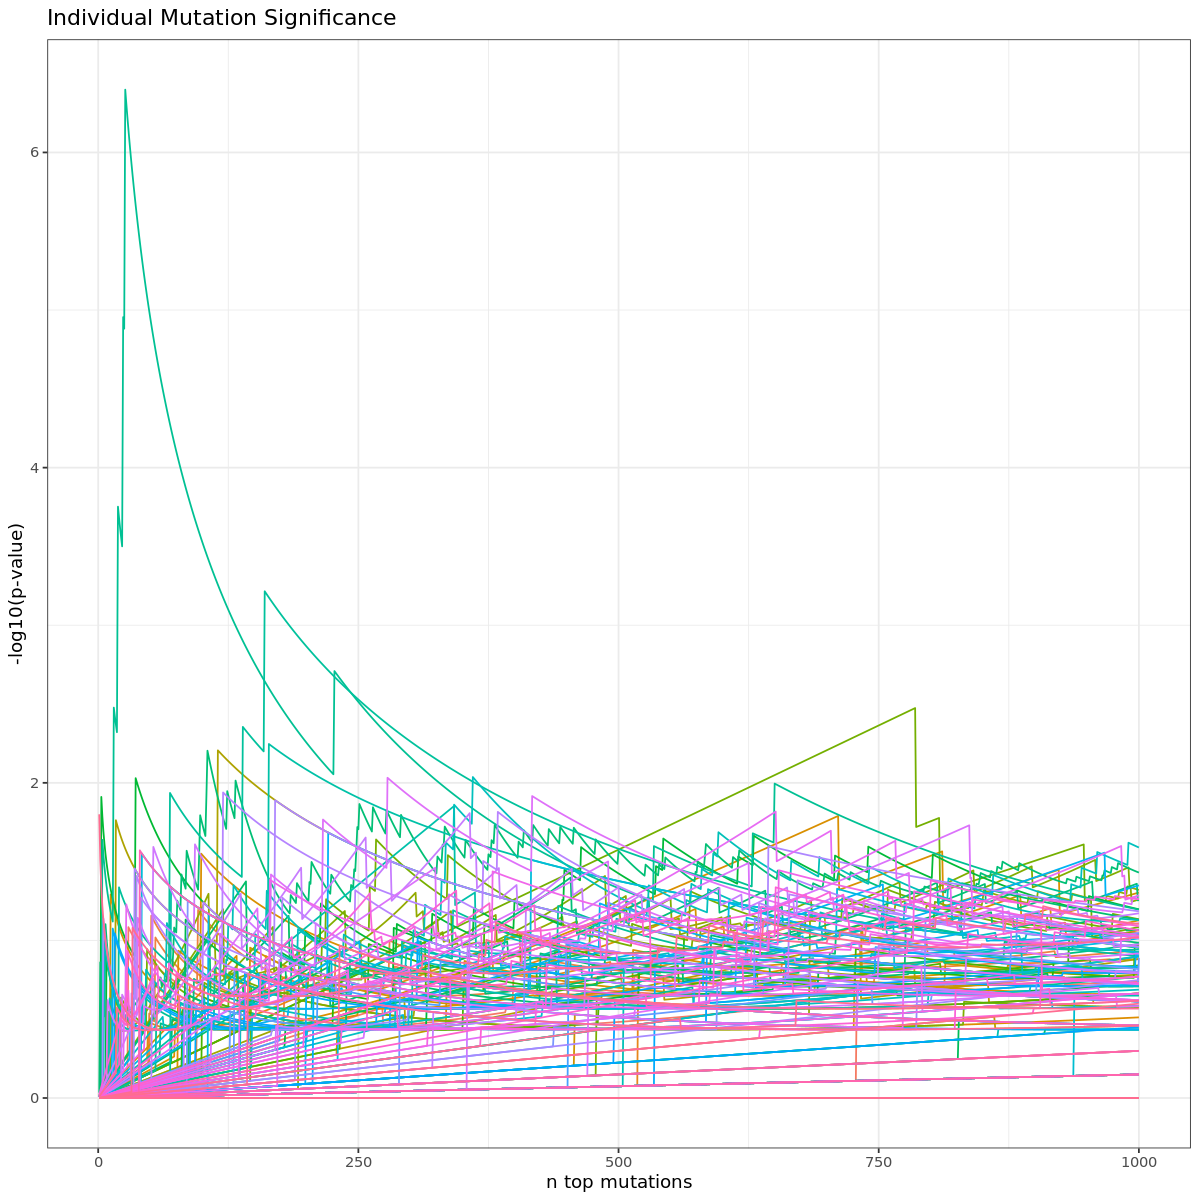

In [26]:
info %>%
    ggplot(aes(x=n,y=-log10(value), color = aa_change)) + 
    geom_line() + 
    theme_bw() + 
    ggtitle('Individual Mutation Significance') +
    theme(legend.position='none') + 
    scale_x_continuous(name='n top mutations') + 
    scale_y_continuous(name='-log10(p-value)') -> plot_individual_mutation_significance

plot_individual_mutation_significance

In [27]:
ggsave(paste0(output_plot_dir,'plot_individual_mutation_significance.png'), width=6, height=6, dpi = plot_dpi)

Warning message:
“Removed 20000 row(s) containing missing values (geom_path).”


In [28]:
info %>% filter(!is.na(value)) %>% 
    group_by(aa_change) %>% 
    summarise(min_pval = min(value)) %>% 
    arrange(min_pval) %>% 
    filter(min_pval < pval_cutoff)

aa_change,min_pval
<chr>,<dbl>
K->N,3.997689e-07


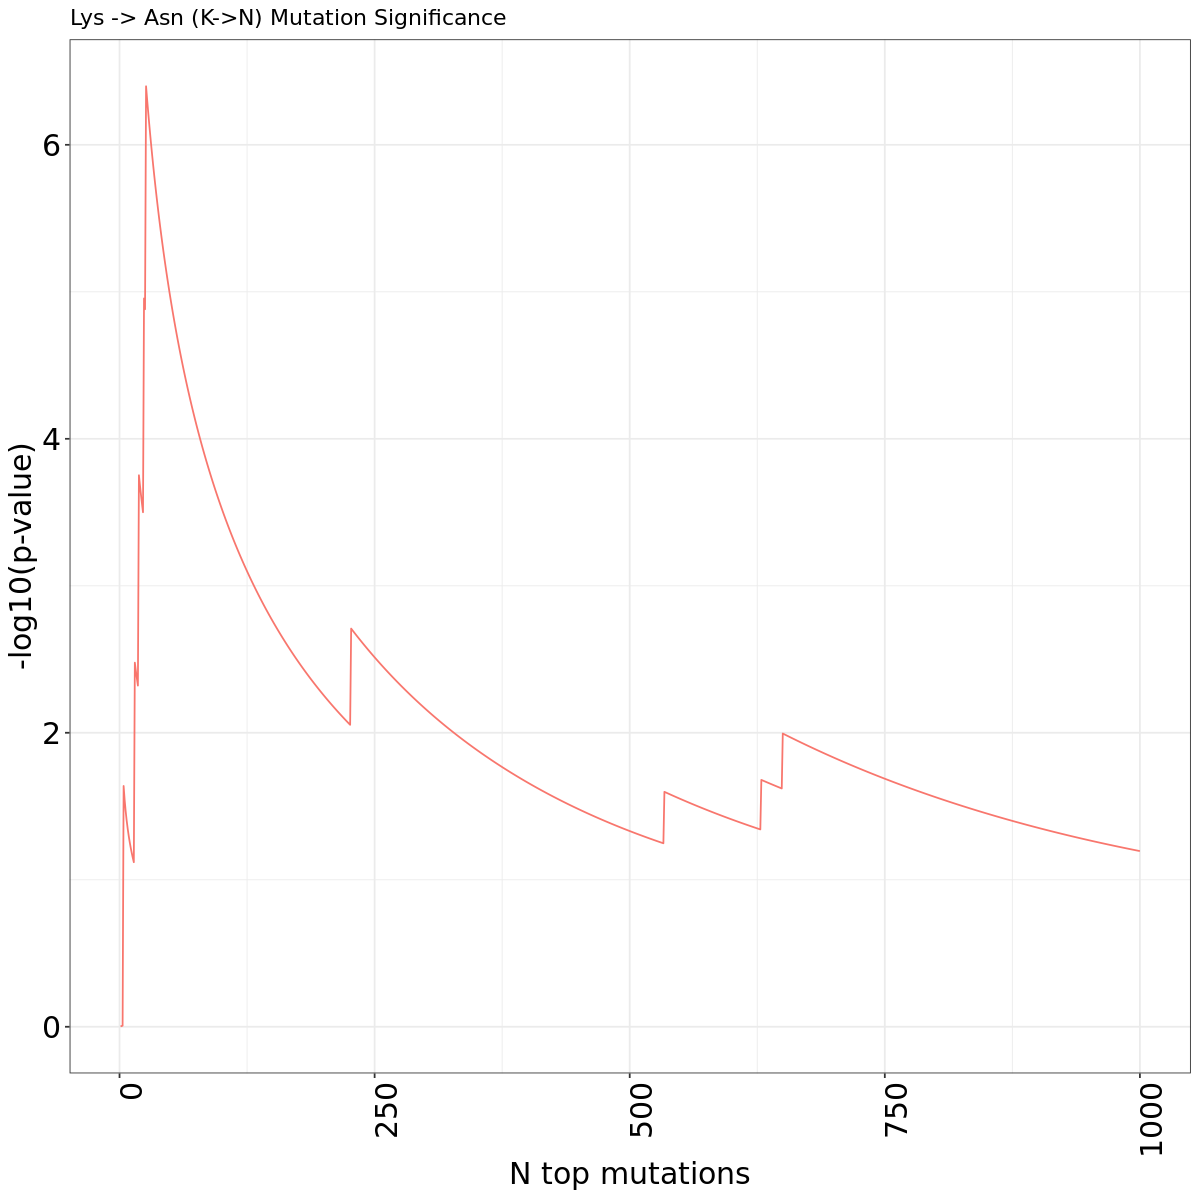

In [42]:
font_size = 18

info %>% filter(!is.na(value)) %>% 
    filter(aa_change == 'K->N') %>%
    ggplot(aes(x=n,y=-log10(value), color = aa_change)) + 
    geom_line() + 
    theme_bw() + 
    ggtitle('Lys -> Asn (K->N) Mutation Significance') +
    theme(legend.position='none',
          axis.text.x = element_text(color='black', size=font_size, angle = 90, hjust=1), 
          axis.text.y = element_text(color='black', size=font_size), 
          axis.title.y = element_text(color='black', size=font_size),
          axis.title.x = element_text(color='black', size=font_size),
          strip.text.x = element_text(color='black', size=font_size)
         ) + 
    scale_x_continuous(name='N top mutations') + 
    scale_y_continuous(name='-log10(p-value)') -> plot_n_to_k_mutation_significance

plot_n_to_k_mutation_significance

In [43]:
ggsave(paste0(output_plot_dir,'plot_k_to_n_mutation_significance.png'), width=6, height=6, dpi = plot_dpi)

## Tabulate Top 1000 Mutations by Gene

In [44]:
n_mutations <- 1000

unique(strpart(res_mutations$mutation,':',1)) -> sars_cov2_genes
names(sars_cov2_genes) <- sars_cov2_genes

do.call(rbind, lapply(sars_cov2_genes, function(g) {
    get_mutation_summary(res_mutations, n_mutations = n_mutations, select_gene = g,return_matrix = FALSE) %>% 
        mutate(aa_change=paste0(aa_from, '->', aa_to)) %>%
        mutate(aa_from = NULL, aa_to = NULL, gene = g) -> df
    df
})) -> df

df %>% pivot_wider(id_cols = c(aa_change, gene), values_from = n, names_from = aa_change,values_fill = 0) -> tmp1
tmp_rn <- tmp1$gene
tmp1 <- tmp1[,-1]
tmp1 <- as.matrix(tmp1)
rownames(tmp1) <- tmp_rn
n_mutations_by_gene <- tmp1

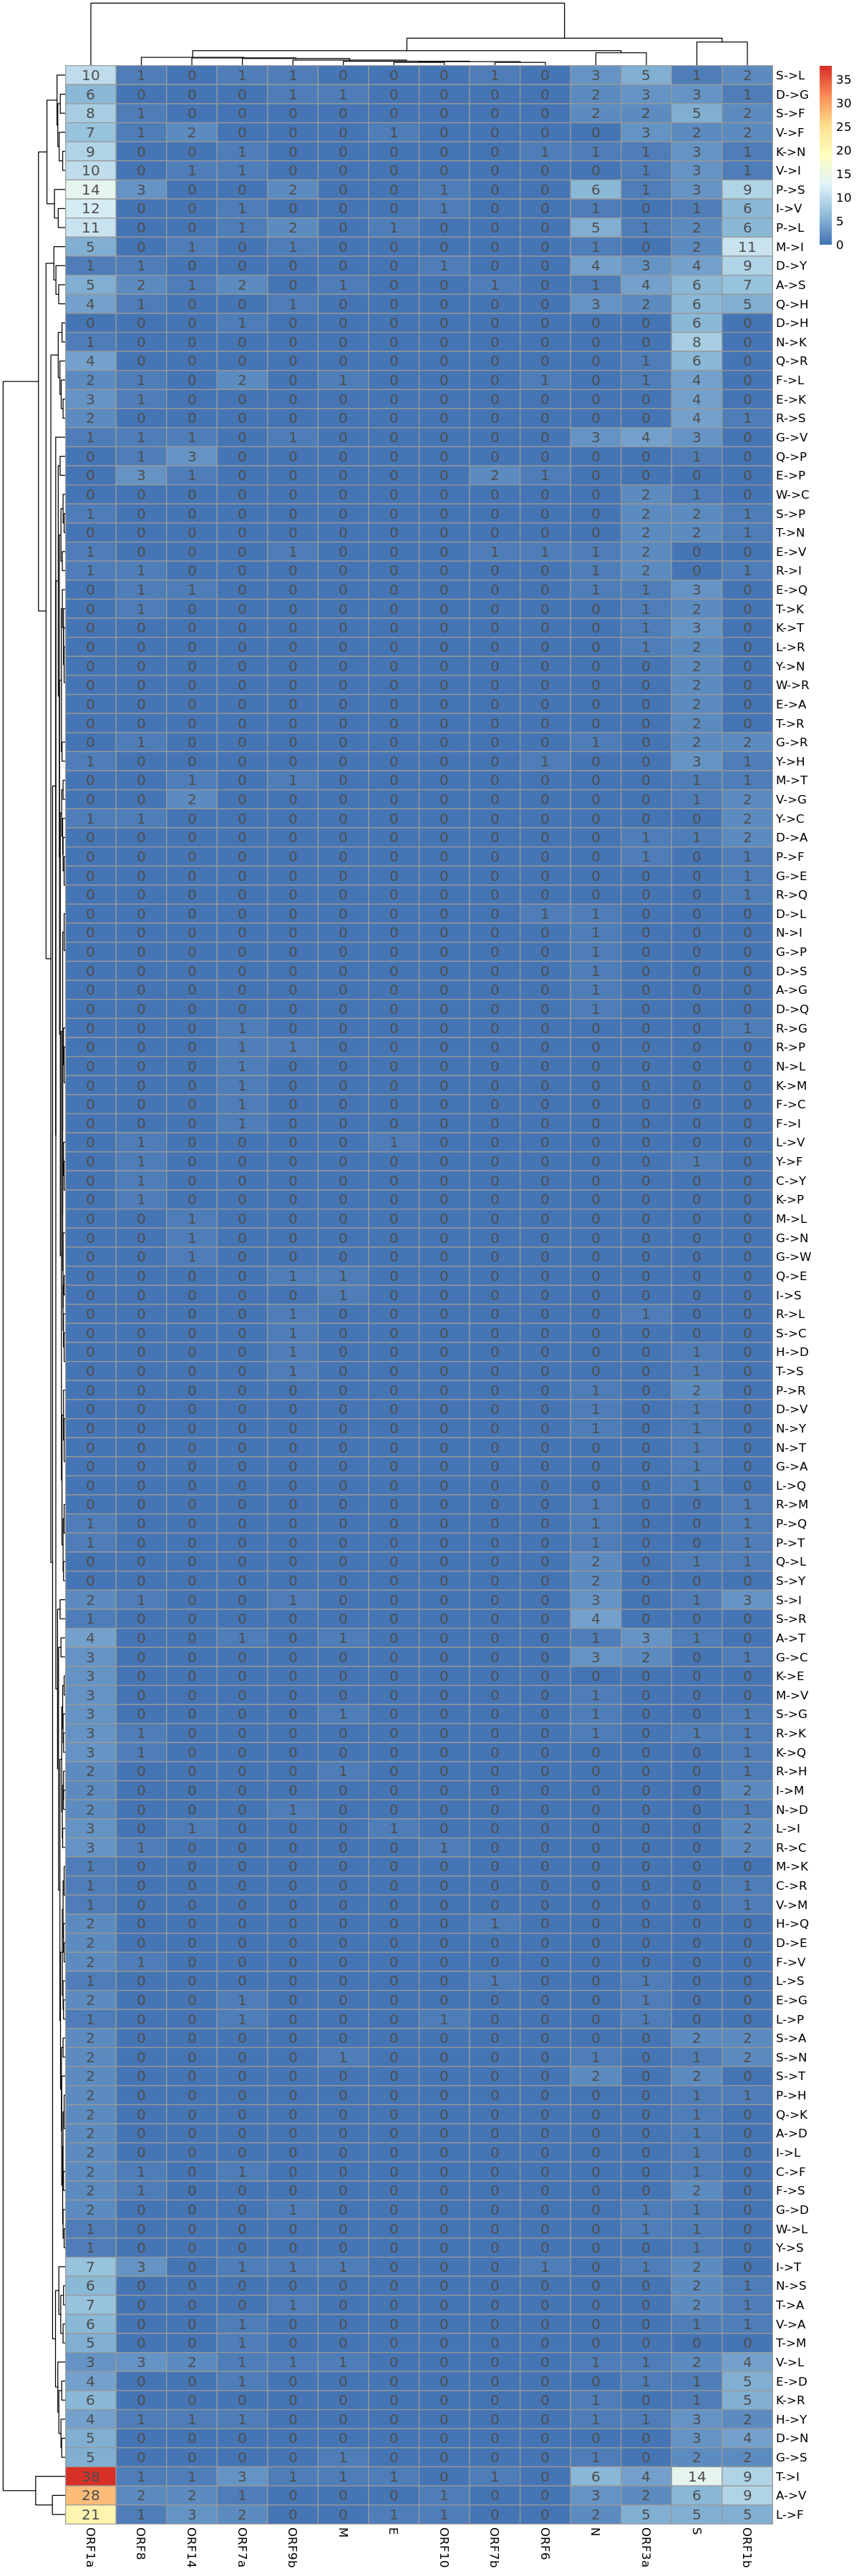

In [45]:
options(repr.plot.width=10, repr.plot.height=30)
pheatmap(t(tmp1),display_numbers = TRUE, number_format = '%.0f', fontsize_number = 12)
options(repr.plot.width=10, repr.plot.height=10)

In [46]:
# repeat saving to disk
pheatmap(t(tmp1),display_numbers = TRUE, number_format = '%.0f', fontsize_number = 12, filename = paste0(output_plot_dir,'by_gene_heatmap.png'), width=10, height=30)

# Mutational Enrichment on a per-gene basis

In [47]:
unique(strpart(res_mutations$mutation, ':', 1)) -> available_genes
available_genes

[1] "S"     "ORF1a" "E"     "ORF9b" "N"     "M"     "ORF1b" "ORF14" "ORF3a"
[10] "ORF7a" "ORF7b" "ORF8"  "ORF6"  "ORF10"

## S gene

In [48]:
get_serial_enrichment_by_gene <- function(res_mutations, select_gene, n_end = 3000,  step=10) {
    most_sign_pval_sym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10, symmetric = TRUE, summary_fn=summary_fn_min, select_gene = select_gene)
    most_sign_pval_sym$type <- 'most'
    most_sign_pval_sym$sym <- 'symmetric'

    most_sign_pval_nonsym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10,symmetric = FALSE, summary_fn=summary_fn_min, select_gene = select_gene)
    most_sign_pval_nonsym$type <- 'most'
    most_sign_pval_nonsym$sym <- 'non-symmetric'

    mean_sign_pval_sym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10,symmetric = TRUE, summary_fn=summary_fn_mean, select_gene = select_gene)
    mean_sign_pval_sym$type <- 'mean'
    mean_sign_pval_sym$sym <- 'symmetric'

    mean_sign_pval_nonsym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10,symmetric = FALSE, summary_fn=summary_fn_mean, select_gene = select_gene)
    mean_sign_pval_nonsym$type <- 'mean'
    mean_sign_pval_nonsym$sym <- 'non-symmetric'

    rbind(most_sign_pval_sym, most_sign_pval_nonsym, mean_sign_pval_sym, mean_sign_pval_nonsym)   
}

In [49]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'S') -> serial_enrichment_S

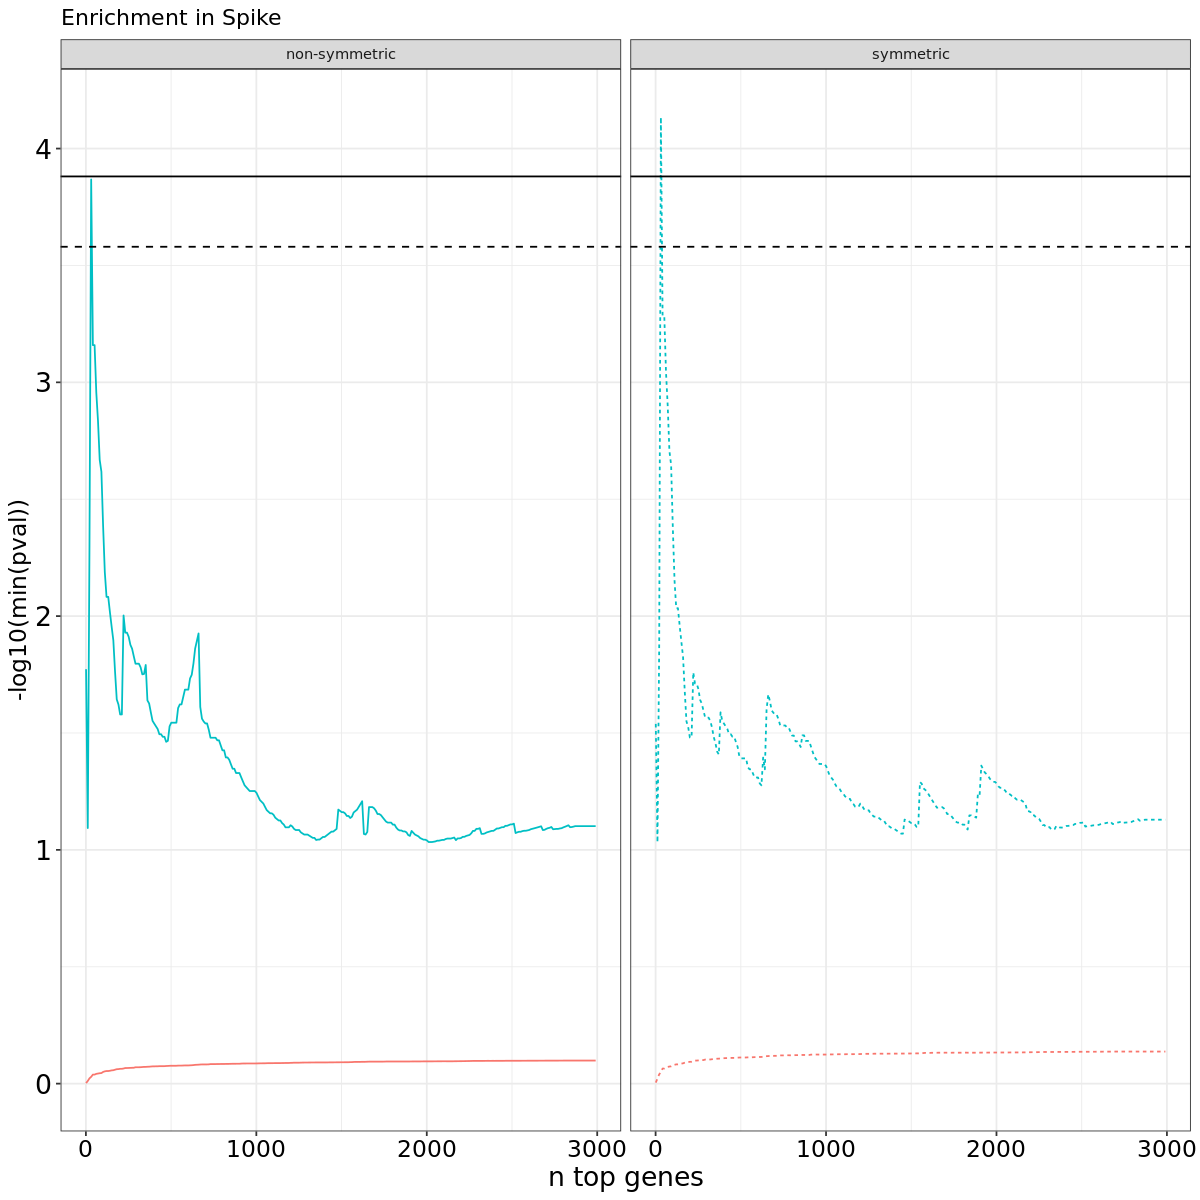

In [50]:
serial_enrichment_S %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        facet_wrap(~sym) +
        theme_bw() + 
        theme(axis.text.x = element_text(color='black', size=14), axis.text.y = element_text(color='black', size=16), axis.title.x = element_text(color='black', size=16), axis.title.y = element_text(color='black', size=14),
         legend.position = "none") +
        scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in Spike') -> plot_pval_vs_top_genes_S

plot_pval_vs_top_genes_S

In [51]:
ggsave(paste0(output_plot_dir,'plot_pval_vs_top_genes_S.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_S)

Look at per aa

In [52]:
info <- test_individual_mutation_enrichment_serial(res_mutations,1,1000, symmetric=FALSE, select_gene = 'S')

Warning message:
“Removed 20000 row(s) containing missing values (geom_path).”


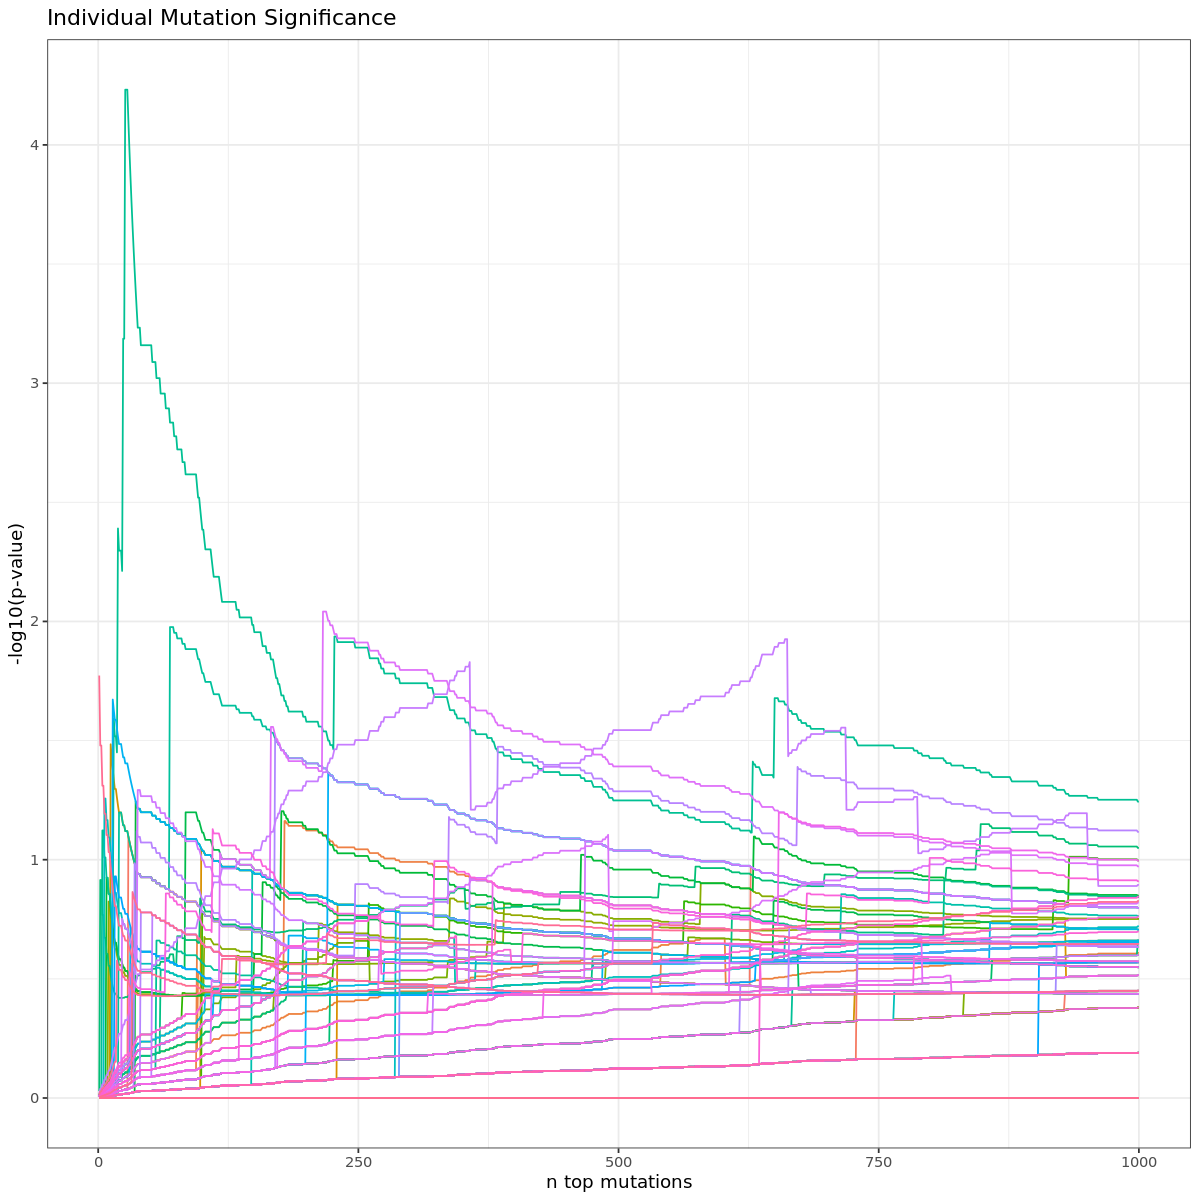

In [53]:
info %>%
    ggplot(aes(x=n,y=-log10(value), color = aa_change)) + 
    geom_line() + 
    theme_bw() + 
    ggtitle('Individual Mutation Significance') +
    theme(legend.position='none') + 
    scale_x_continuous(name='n top mutations') + 
    scale_y_continuous(name='-log10(p-value)') -> plot_individual_mutation_significance_S

plot_individual_mutation_significance_S

In [54]:
ggsave(paste0(output_plot_dir,'plot_individual_mutation_significance_S.png'), width=6, height=6, dpi = plot_dpi, plot = plot_individual_mutation_significance_S)

Warning message:
“Removed 20000 row(s) containing missing values (geom_path).”


In [55]:
info %>% filter(!is.na(value)) %>% 
    group_by(aa_change) %>% 
    summarise(min_pval = min(value)) %>% 
    arrange(min_pval) %>% 
    filter(min_pval < pval_cutoff)

aa_change,min_pval
<chr>,<dbl>
K->N,5.86506e-05


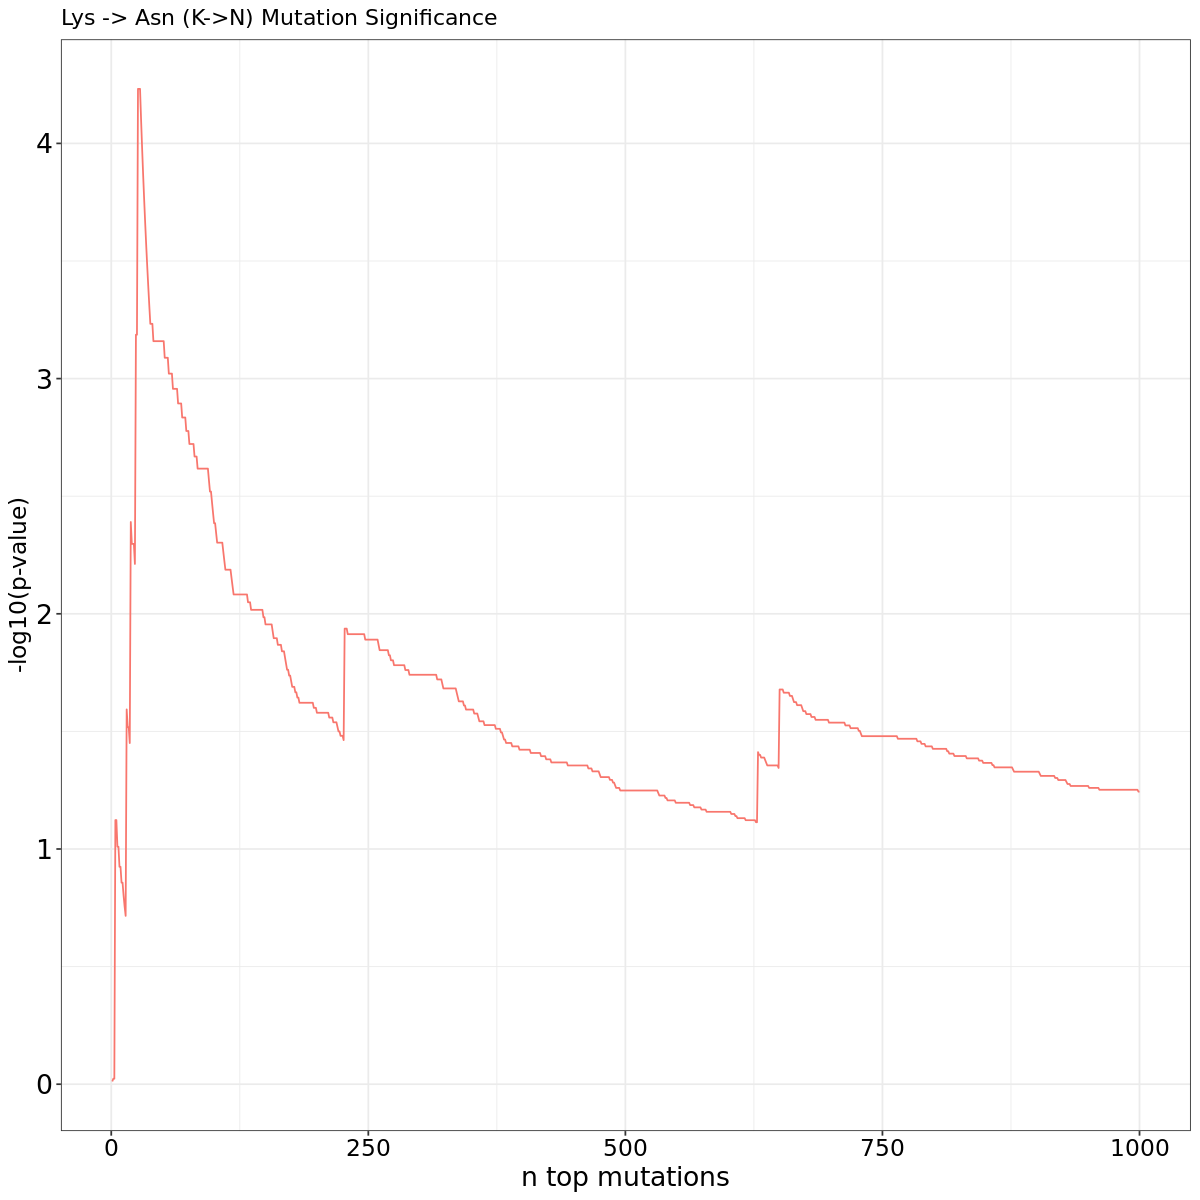

In [56]:
info %>% filter(!is.na(value)) %>% 
    filter(aa_change == 'K->N') %>%
    ggplot(aes(x=n,y=-log10(value), color = aa_change)) + 
    geom_line() + 
    theme_bw() + 
    theme(axis.text.x = element_text(color='black', size=14), axis.text.y = element_text(color='black', size=16), axis.title.x = element_text(color='black', size=16), axis.title.y = element_text(color='black', size=14), legend.position = "none") +
    ggtitle('Lys -> Asn (K->N) Mutation Significance') +
    theme(legend.position='none') + 
    scale_x_continuous(name='n top mutations') + 
    scale_y_continuous(name='-log10(p-value)') -> plot_n_to_k_mutation_significance_S__K_to_N

plot_n_to_k_mutation_significance_S__K_to_N

In [57]:
ggsave(paste0(output_plot_dir,'plot_individual_mutation_significance_S__K_to_N.png'), width=6, height=6, dpi = plot_dpi, plot = plot_n_to_k_mutation_significance_S__K_to_N)

## M gene

In [58]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'M') -> serial_enrichment_M

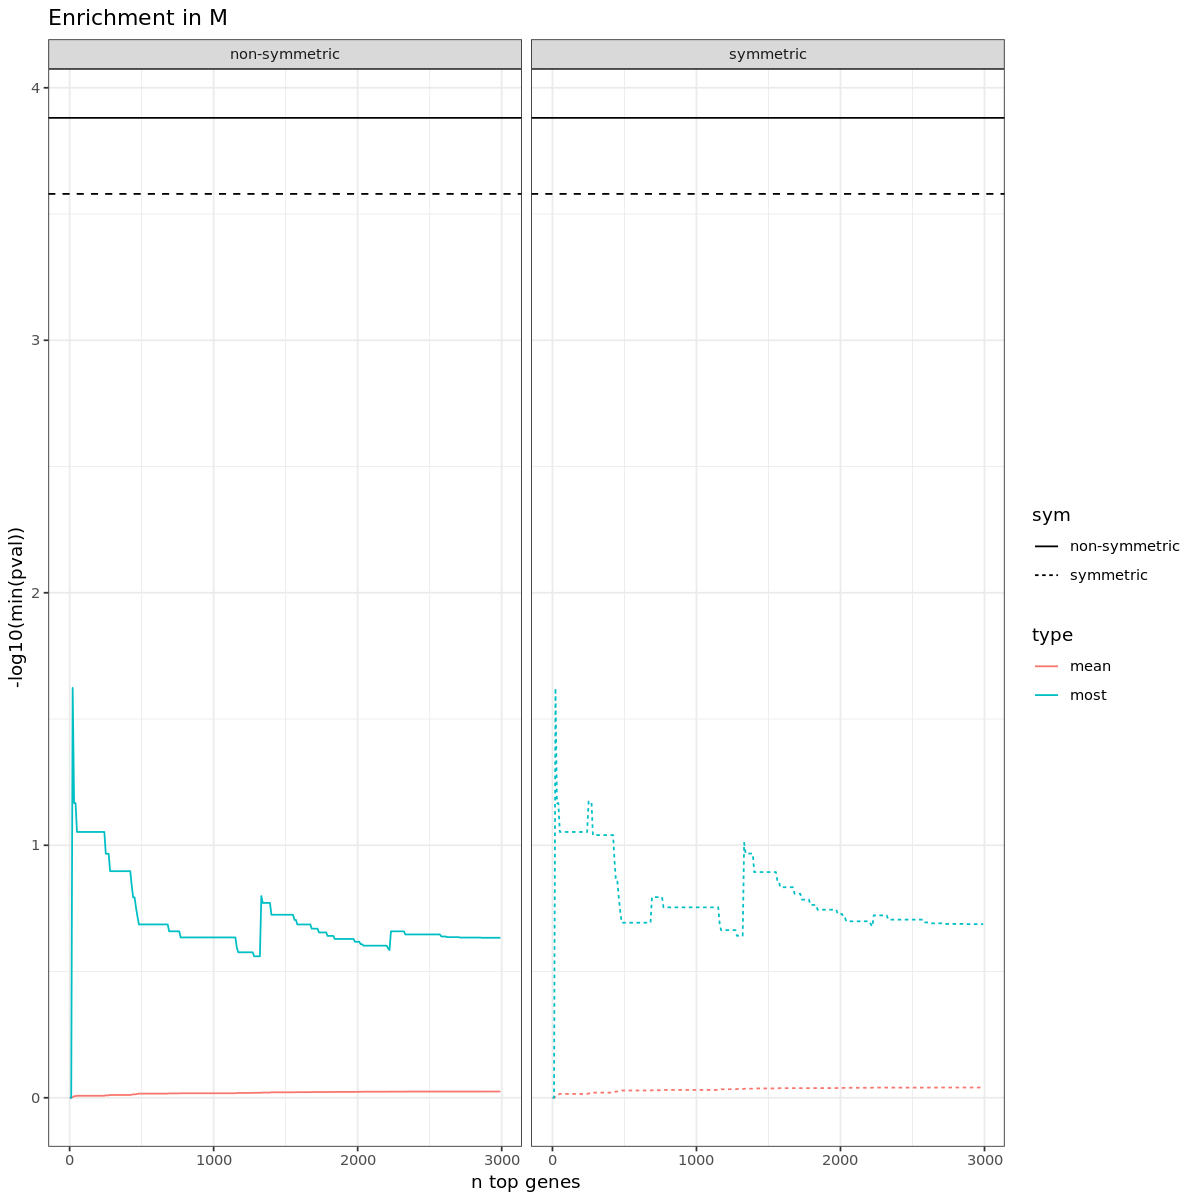

In [59]:
serial_enrichment_M %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        theme(axis.text.x = element_text(color='black', size=14), axis.text.y = element_text(color='black', size=16), axis.title.x = element_text(color='black', size=16), axis.title.y = element_text(color='black', size=14), legend.position = "none") +
        facet_wrap(~sym) +
        theme_bw() + scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in M') -> plot_pval_vs_top_genes_M

plot_pval_vs_top_genes_M

In [60]:
ggsave(paste0(output_plot_dir,'plot_individual_mutation_significance_M.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_M)

## N gene

In [61]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'N') -> serial_enrichment_N

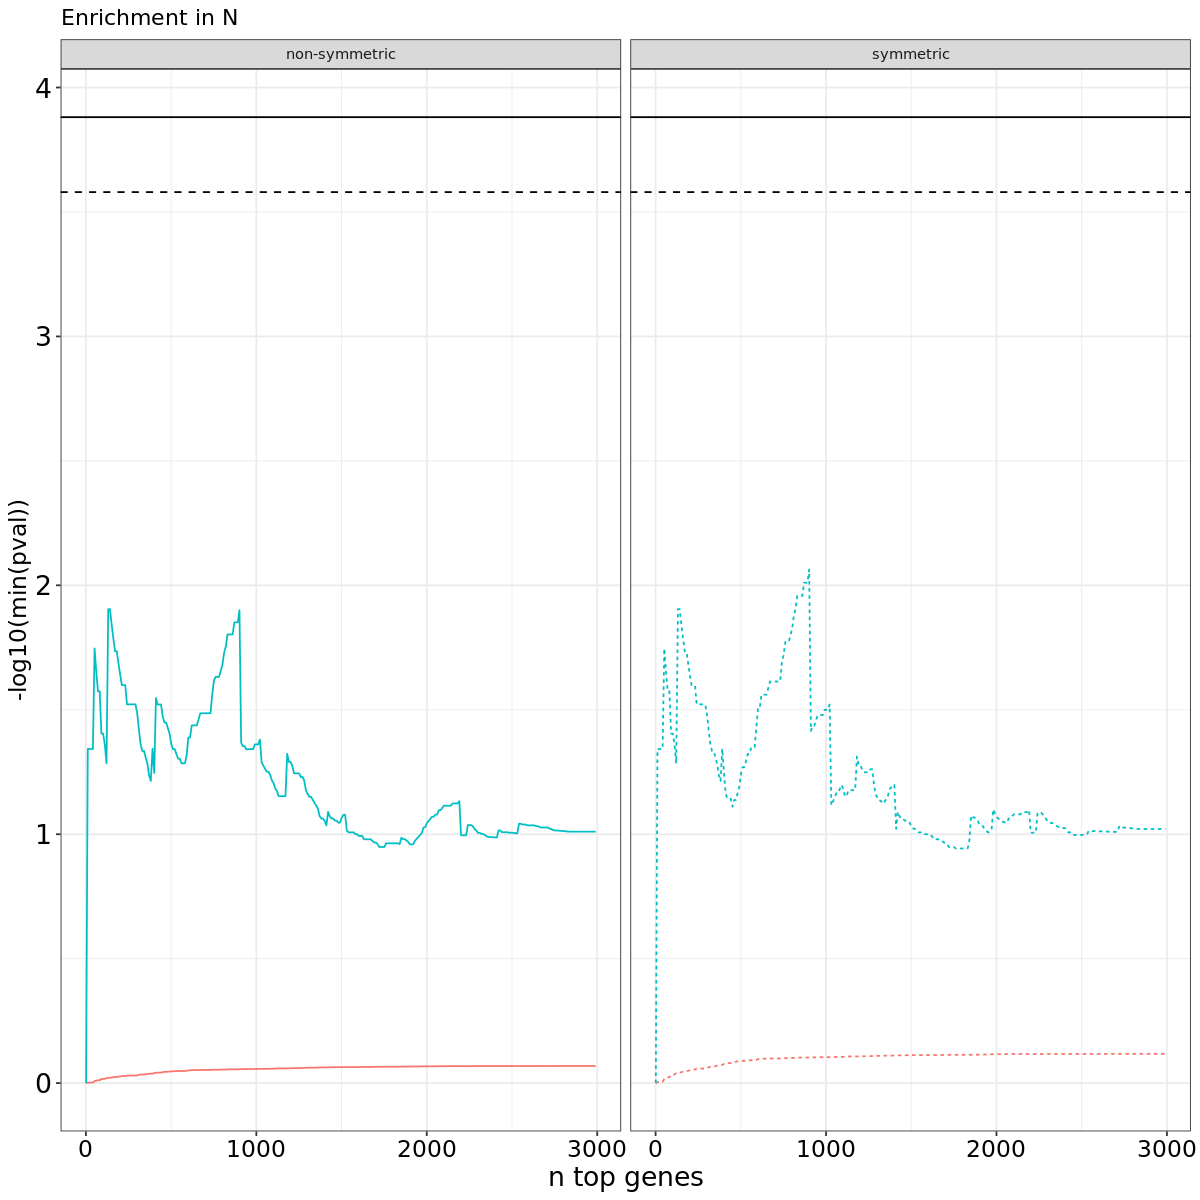

In [62]:
serial_enrichment_N %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        theme_bw() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        theme(axis.text.x = element_text(color='black', size=14), axis.text.y = element_text(color='black', size=16), axis.title.x = element_text(color='black', size=16), axis.title.y = element_text(color='black', size=14), legend.position = "none") +
        facet_wrap(~sym) +
         scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in N') -> plot_pval_vs_top_genes_N

plot_pval_vs_top_genes_N

In [63]:
ggsave(paste0(output_plot_dir,'plot_pval_vs_top_genes_N.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_N)

## ORF9b

In [64]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'ORF9b') -> serial_enrichment_ORF9b

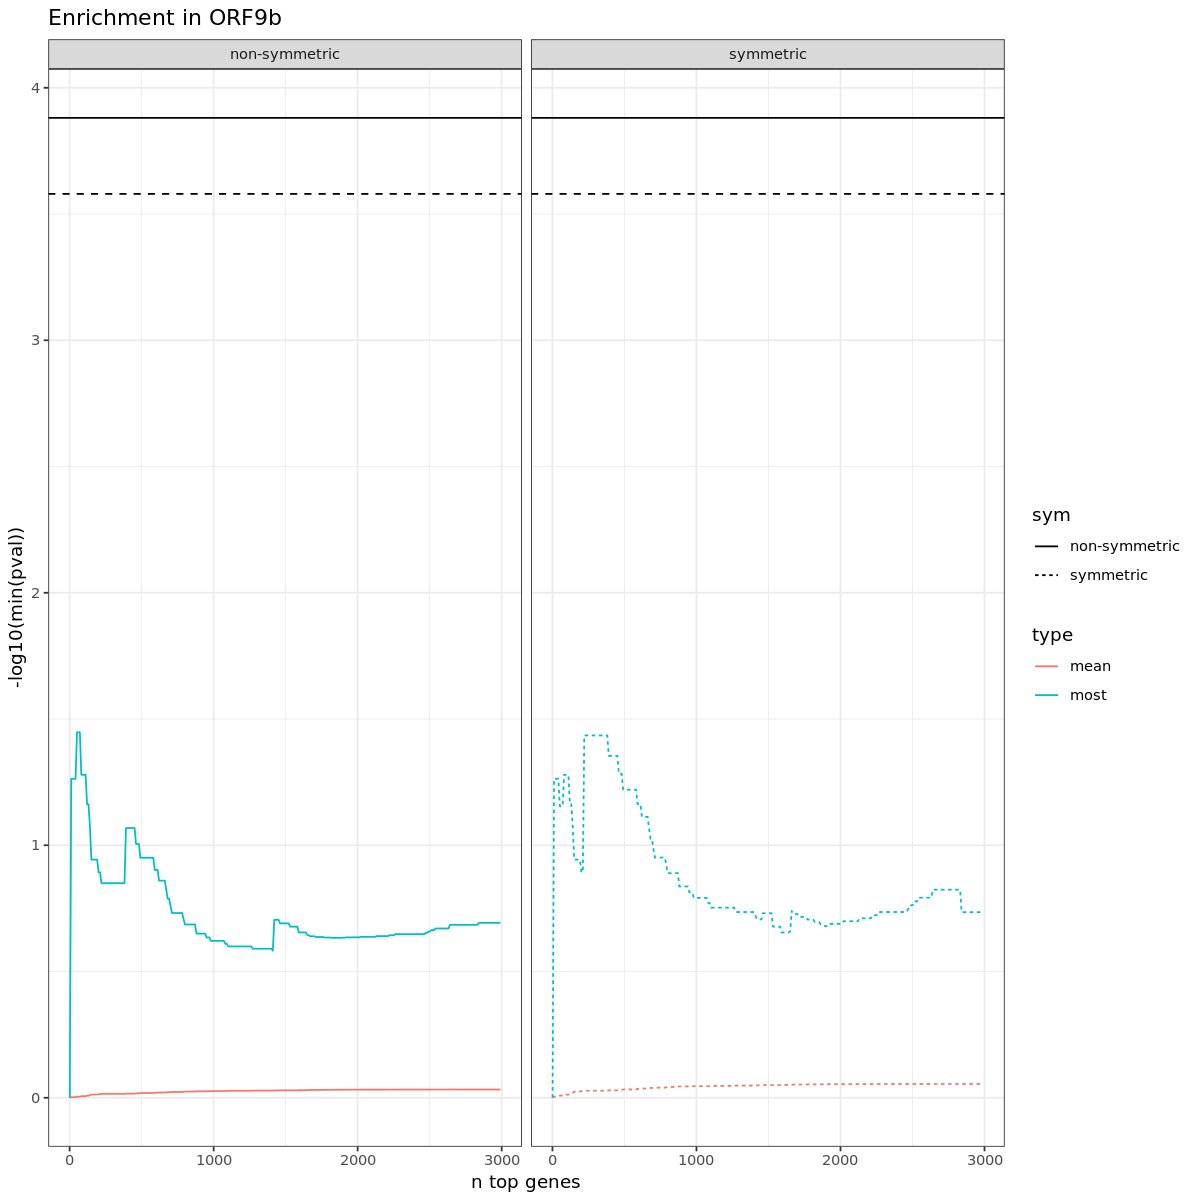

In [65]:
serial_enrichment_ORF9b %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        facet_wrap(~sym) +
        theme_bw() + scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in ORF9b') -> plot_pval_vs_top_genes_ORF9b

plot_pval_vs_top_genes_ORF9b

In [66]:
ggsave(paste0(output_plot_dir,'plot_pval_vs_top_genes_ORF9b.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_ORF9b)

## ORF1a

In [67]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'ORF1a') -> serial_enrichment_ORF1a

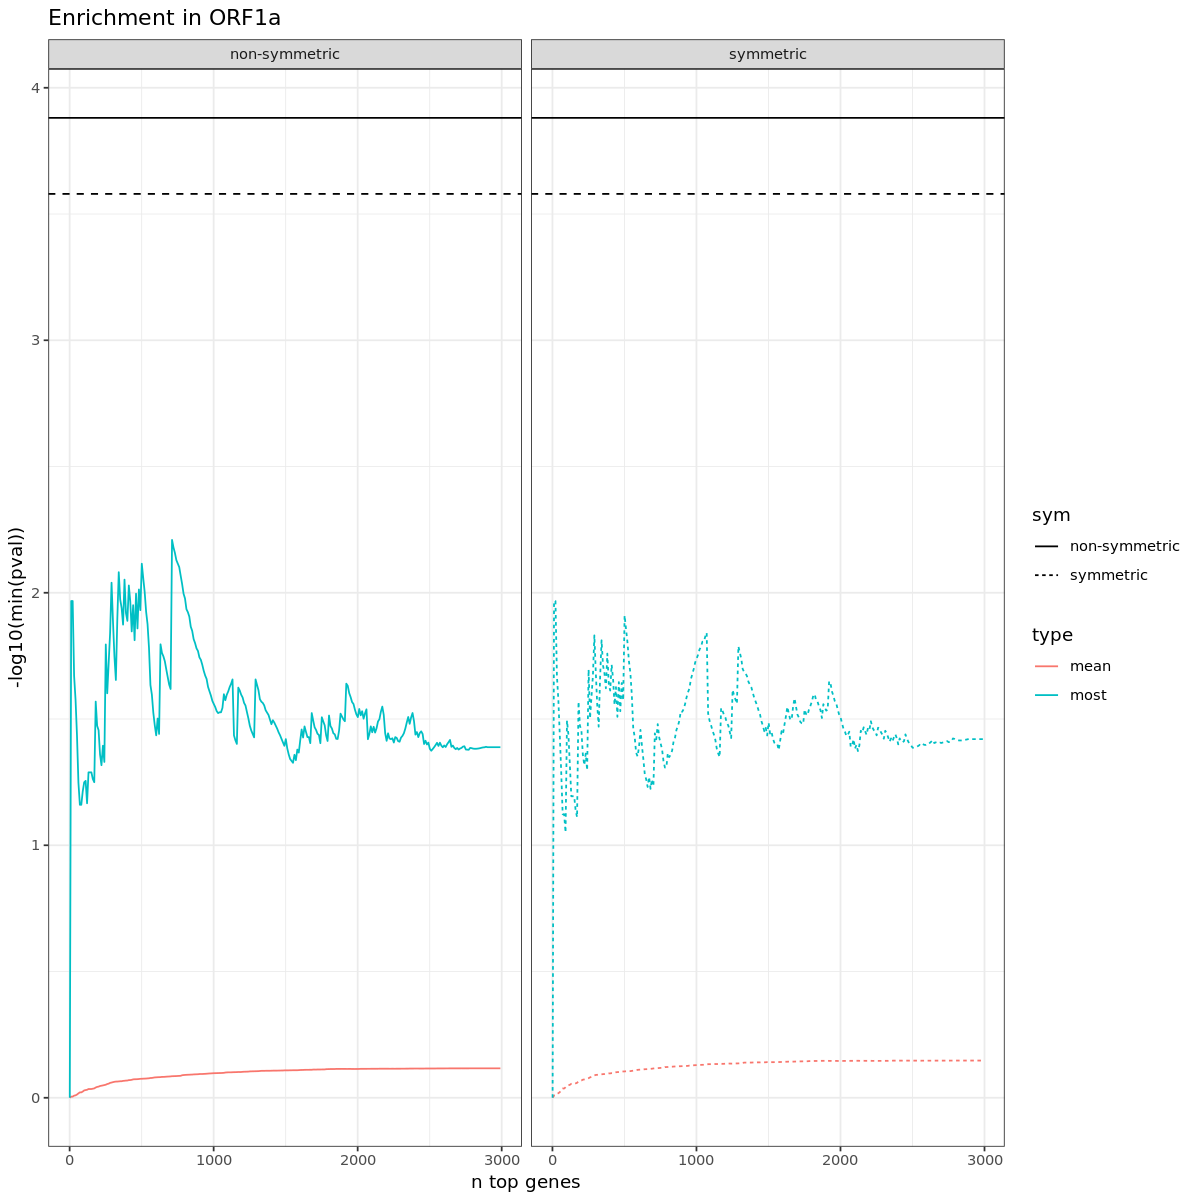

In [68]:
serial_enrichment_ORF1a %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        facet_wrap(~sym) +
        theme_bw() + scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in ORF1a') -> plot_pval_vs_top_genes_ORF1a

plot_pval_vs_top_genes_ORF1a

In [69]:
ggsave(paste0(output_plot_dir,'plot_pval_vs_top_genes_ORF1a.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_ORF1a)

## ORF1b

In [70]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'ORF1b') -> serial_enrichment_ORF1b

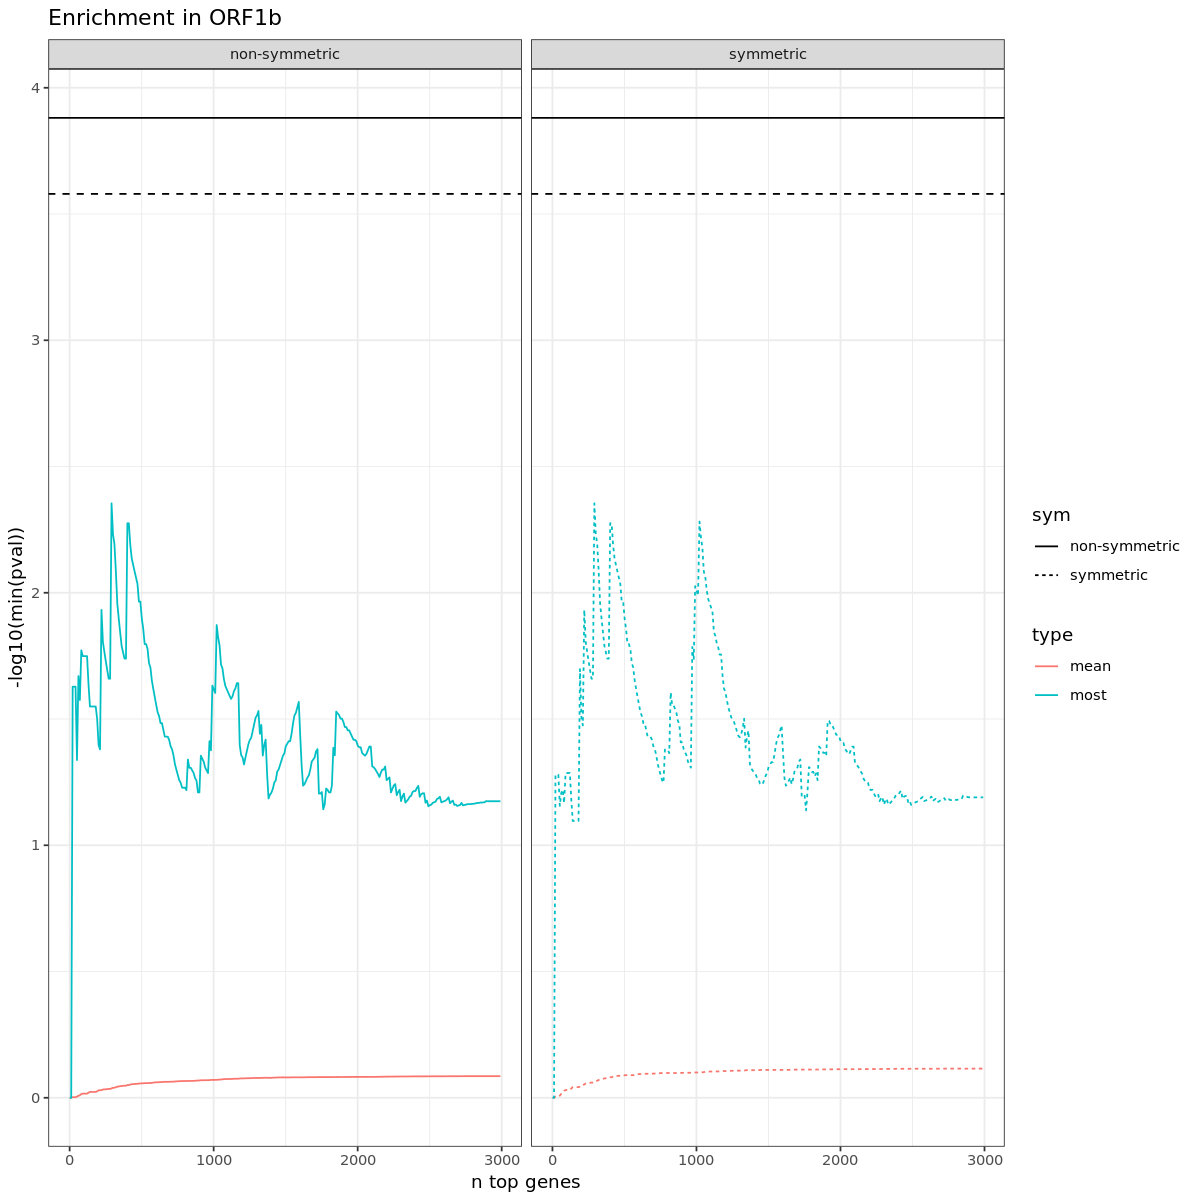

In [71]:
serial_enrichment_ORF1b %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        facet_wrap(~sym) +
        theme_bw() + scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in ORF1b') -> plot_pval_vs_top_genes_ORF1b

plot_pval_vs_top_genes_ORF1b

In [72]:
ggsave(paste0(output_plot_dir,'plot_pval_vs_top_genes_ORF1b.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_ORF1b)

## ORF3a

In [73]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'ORF3a') -> serial_enrichment_ORF3a

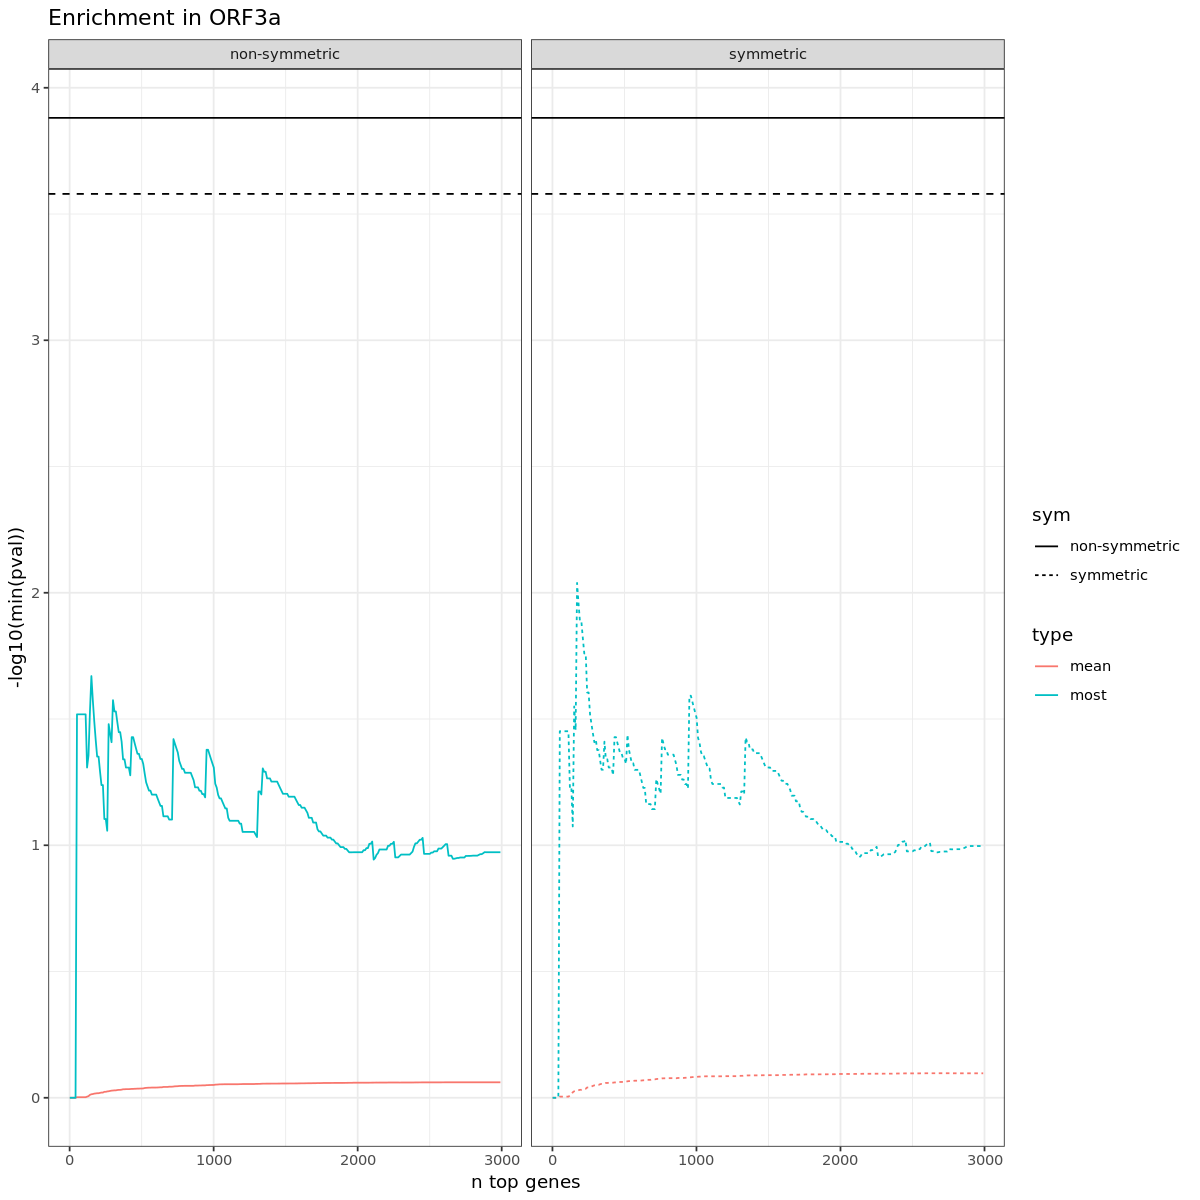

In [74]:
serial_enrichment_ORF3a %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        facet_wrap(~sym) +
        theme_bw() + scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in ORF3a') -> plot_pval_vs_top_genes_ORF3a

plot_pval_vs_top_genes_ORF3a

In [75]:
ggsave(paste0(output_plot_dir,'plot_pval_vs_top_genes_ORF3a.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_ORF3a)

## E

In [76]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'E') -> serial_enrichment_E

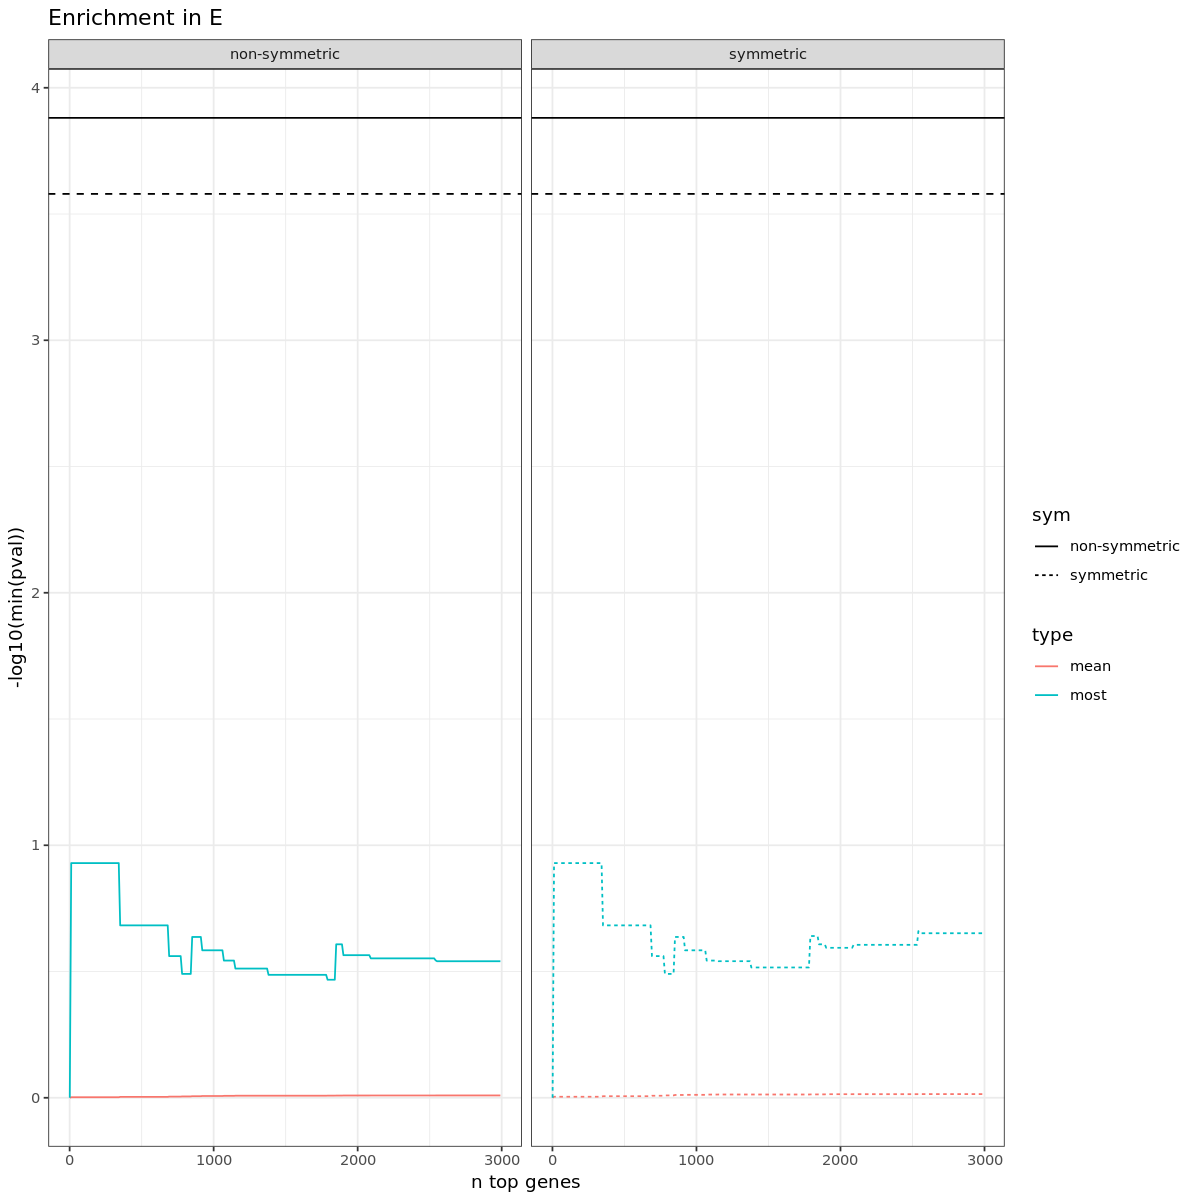

In [77]:
serial_enrichment_E %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        facet_wrap(~sym) +
        theme_bw() + scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in E') -> plot_pval_vs_top_genes_E

plot_pval_vs_top_genes_E

In [78]:
ggsave(paste0(output_plot_dir,'plot_pval_vs_top_genes_E.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_E)

# ORF7b

In [79]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'ORF7b') -> serial_enrichment_ORF7b

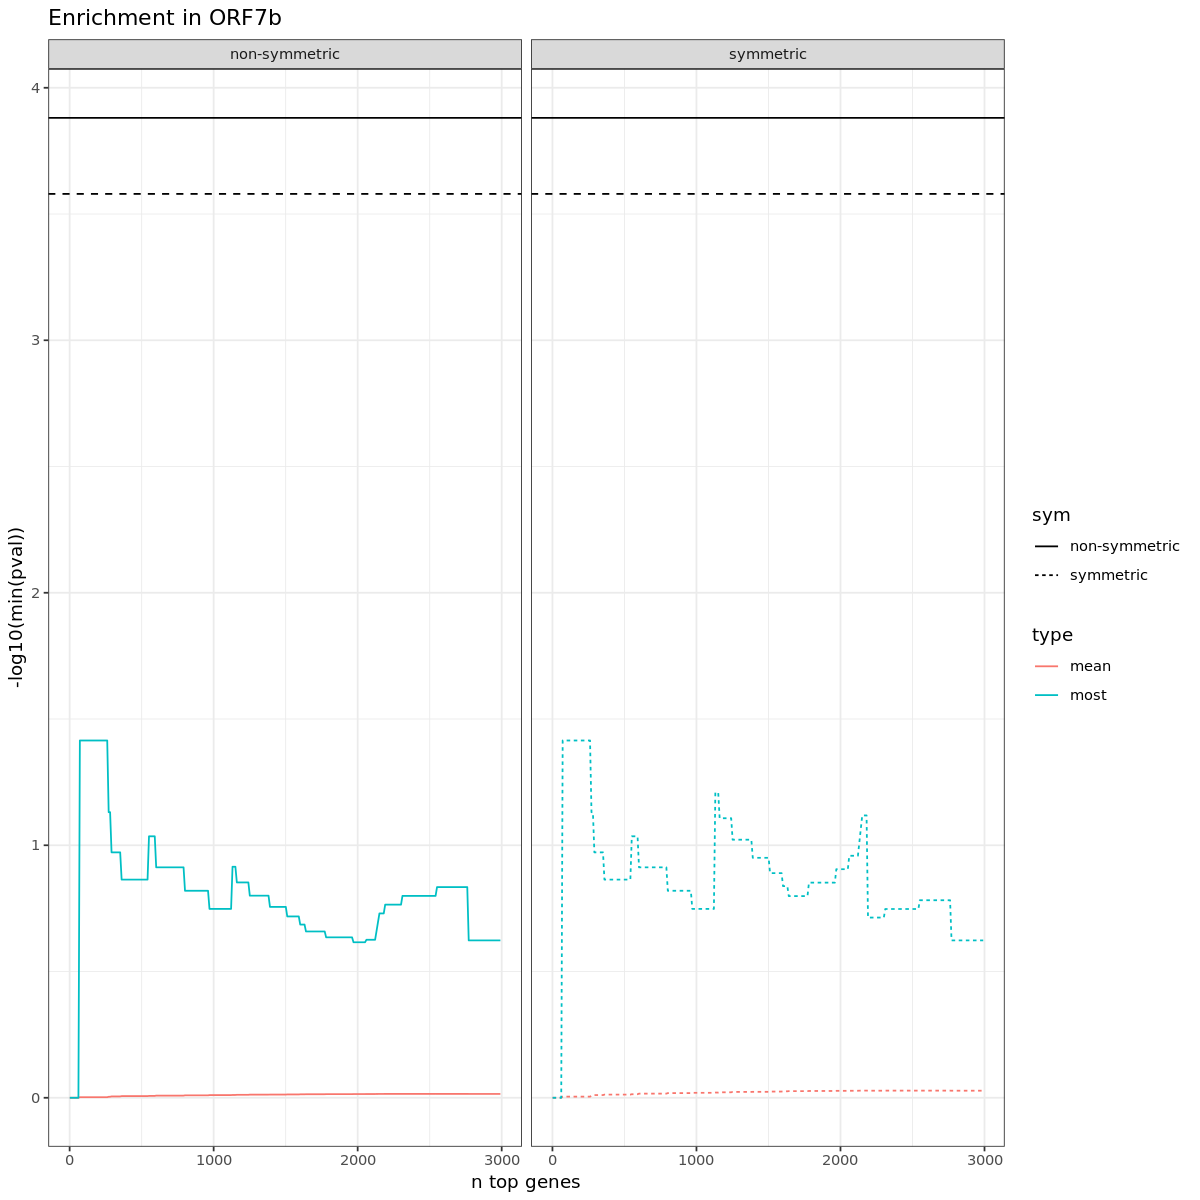

In [82]:
serial_enrichment_ORF7b %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        facet_wrap(~sym) +
        theme_bw() + scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in ORF7b') -> plot_pval_vs_top_genes_ORF7b

plot_pval_vs_top_genes_ORF7b

In [83]:
ggsave(paste0(output_plot_dir,'plot_pval_vs_top_genes_ORF7b.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_ORF7b)

# ORF8

In [84]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'ORF8') -> serial_enrichment_ORF8

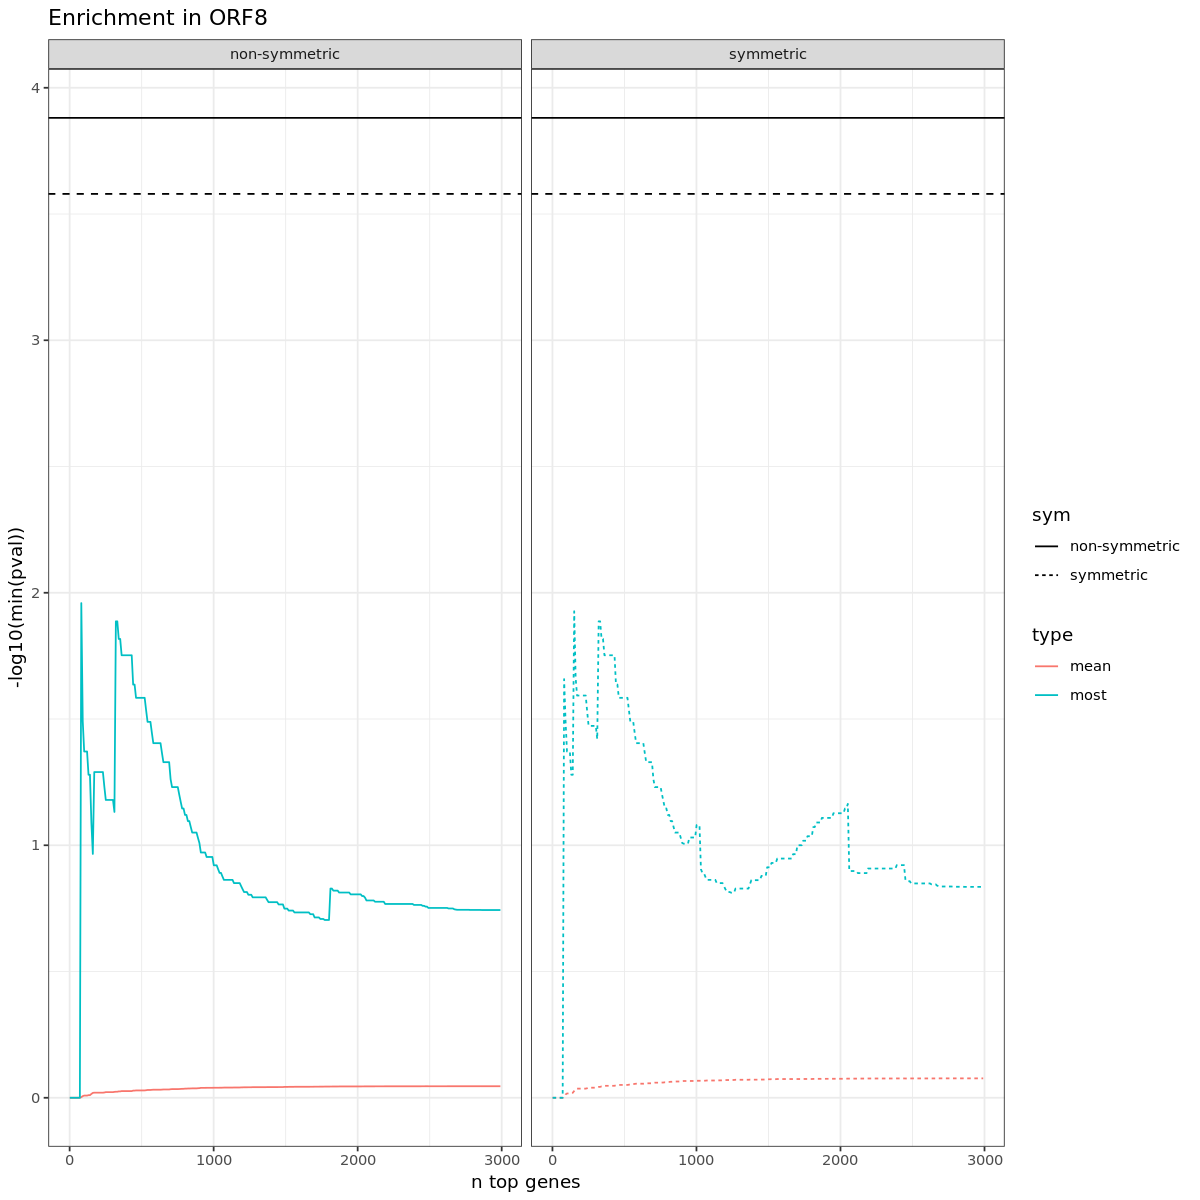

In [85]:
serial_enrichment_ORF8 %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        facet_wrap(~sym) +
        theme_bw() + scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in ORF8') -> plot_pval_vs_top_genes_ORF8

plot_pval_vs_top_genes_ORF8

In [86]:
ggsave(paste0(output_plot_dir,'plot_pval_vs_top_genes_ORF8.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_ORF8)

# ORF6

In [87]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'ORF6') -> serial_enrichment_ORF6

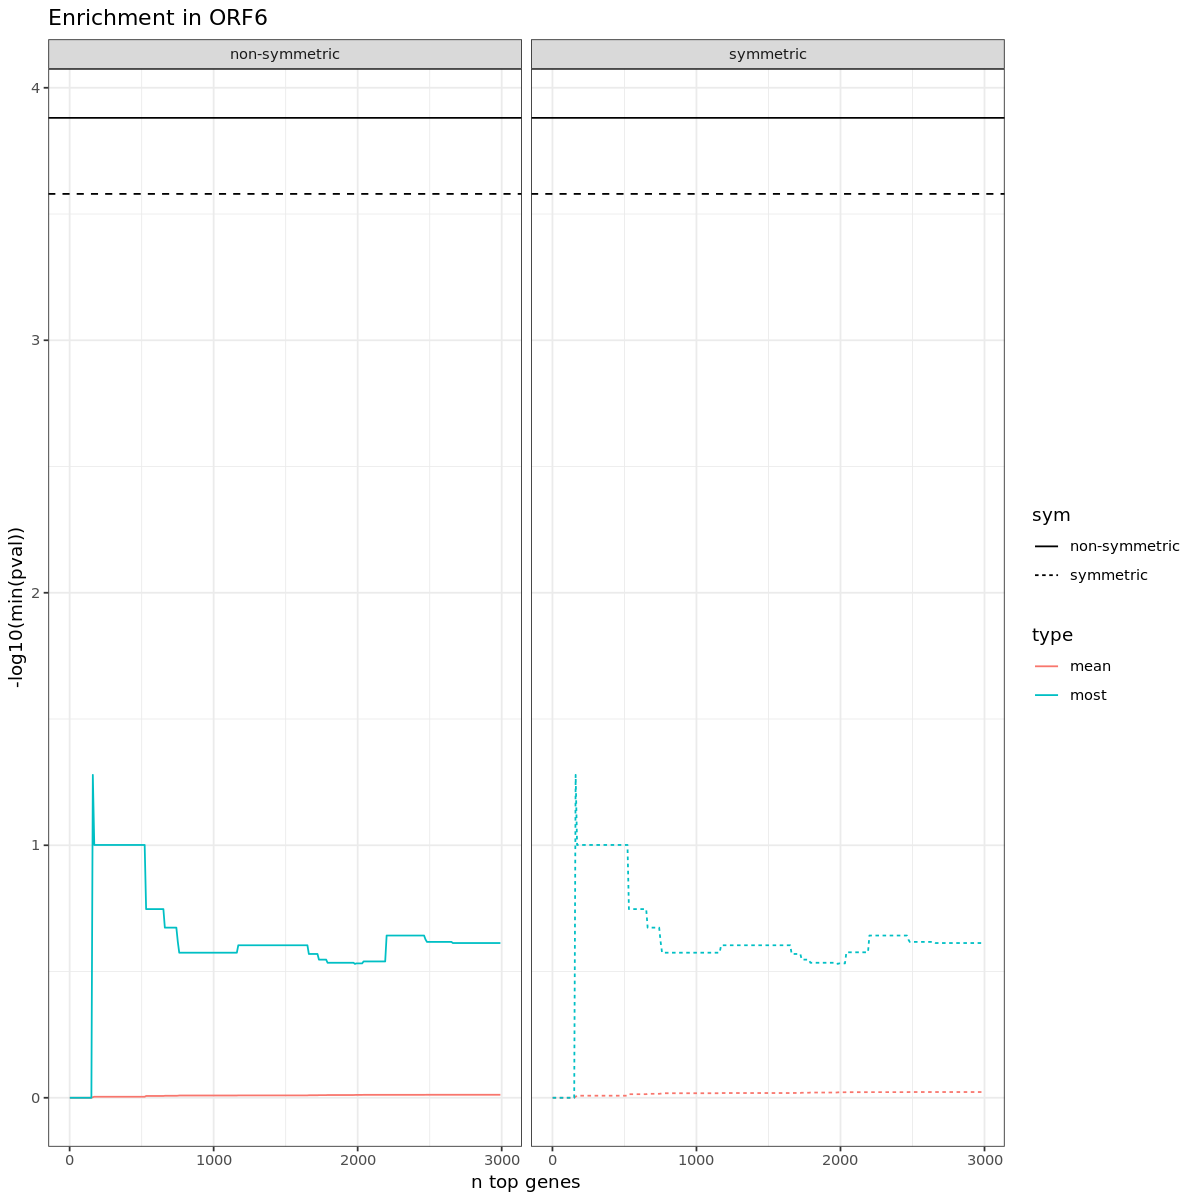

In [88]:
serial_enrichment_ORF6 %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        facet_wrap(~sym) +
        theme_bw() + scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in ORF6') -> plot_pval_vs_top_genes_ORF6

plot_pval_vs_top_genes_ORF6

In [89]:
ggsave(paste0(output_plot_dir,'plot_pval_vs_top_genes_ORF6.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_ORF6)

# ORF10

In [90]:
get_serial_enrichment_by_gene(res_mutations, select_gene = 'ORF10') -> serial_enrichment_ORF10

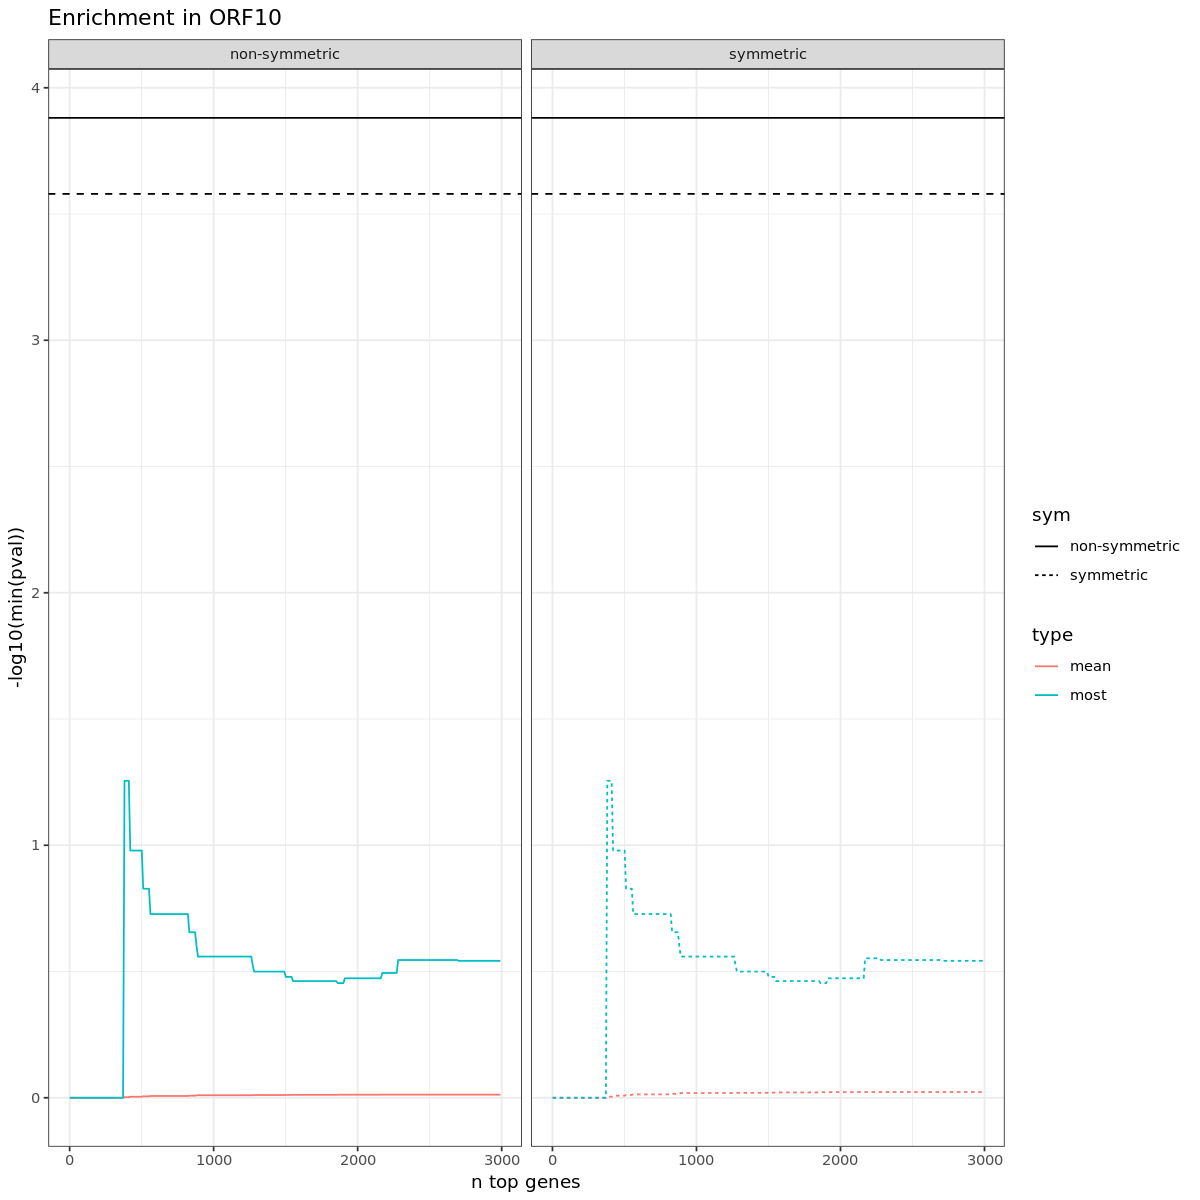

In [91]:
serial_enrichment_ORF10 %>% 
    ggplot(aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
        geom_line() +
        geom_hline(yintercept = -log10(pval_cutoff)) + 
        geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
        facet_wrap(~sym) +
        theme_bw() + scale_x_continuous(name="n top genes") + 
        scale_y_continuous(name="-log10(min(pval))") +
        ggtitle('Enrichment in ORF10') -> plot_pval_vs_top_genes_ORF10

plot_pval_vs_top_genes_ORF10

In [92]:
ggsave(paste0(output_plot_dir,'plot_pval_vs_top_genes_ORF10.png'), width=6, height=6, dpi = plot_dpi, plot = plot_pval_vs_top_genes_ORF10)

## Aggregate plot of serial enrichment by gene

In [ ]:







serial_enrichment_M
serial_enrichment_N
serial_enrichment_ORF9b
serial_enrichment_ORF1a
serial_enrichment_ORF1b
serial_enrichment_ORF3a
serial_enrichment_E
serial_enrichment_ORF7b
serial_enrichment_ORF8
serial_enrichment_ORF6
serial_enrichment_ORF10

In [135]:
head(serial_enrichment_M)

,n,most_sign_pval,type,sym
,<dbl>,<dbl>,<chr>,<chr>
1,1,1.00000000,most,symmetric
2,11,1.00000000,most,symmetric
3,21,0.02380952,most,symmetric
4,31,0.06806770,most,symmetric
5,41,0.06806770,most,symmetric
6,51,0.08859606,most,symmetric


In [147]:
prepare_table <- function(t, g) {
    t[t$type == 'most',] -> t
    t[t$sym != 'symmetric',] -> t
    t$gene = g
    t
}

In [148]:
aggr.dataset <- rbind(
    prepare_table(serial_enrichment_S, 'S'),
    prepare_table(serial_enrichment_M, 'M'),
    prepare_table(serial_enrichment_N, 'N'),
    prepare_table(serial_enrichment_ORF9b, 'ORF9b'),
    prepare_table(serial_enrichment_ORF1a, 'ORF1a'),
    prepare_table(serial_enrichment_ORF1b, 'ORF1b'),
    prepare_table(serial_enrichment_ORF3a, 'ORF3a'),
    prepare_table(serial_enrichment_ORF7b, 'ORF7b'),
    prepare_table(serial_enrichment_ORF8, 'ORF8'),
    prepare_table(serial_enrichment_ORF6, 'ORF6'),
    prepare_table(serial_enrichment_ORF10, 'ORF10')
)

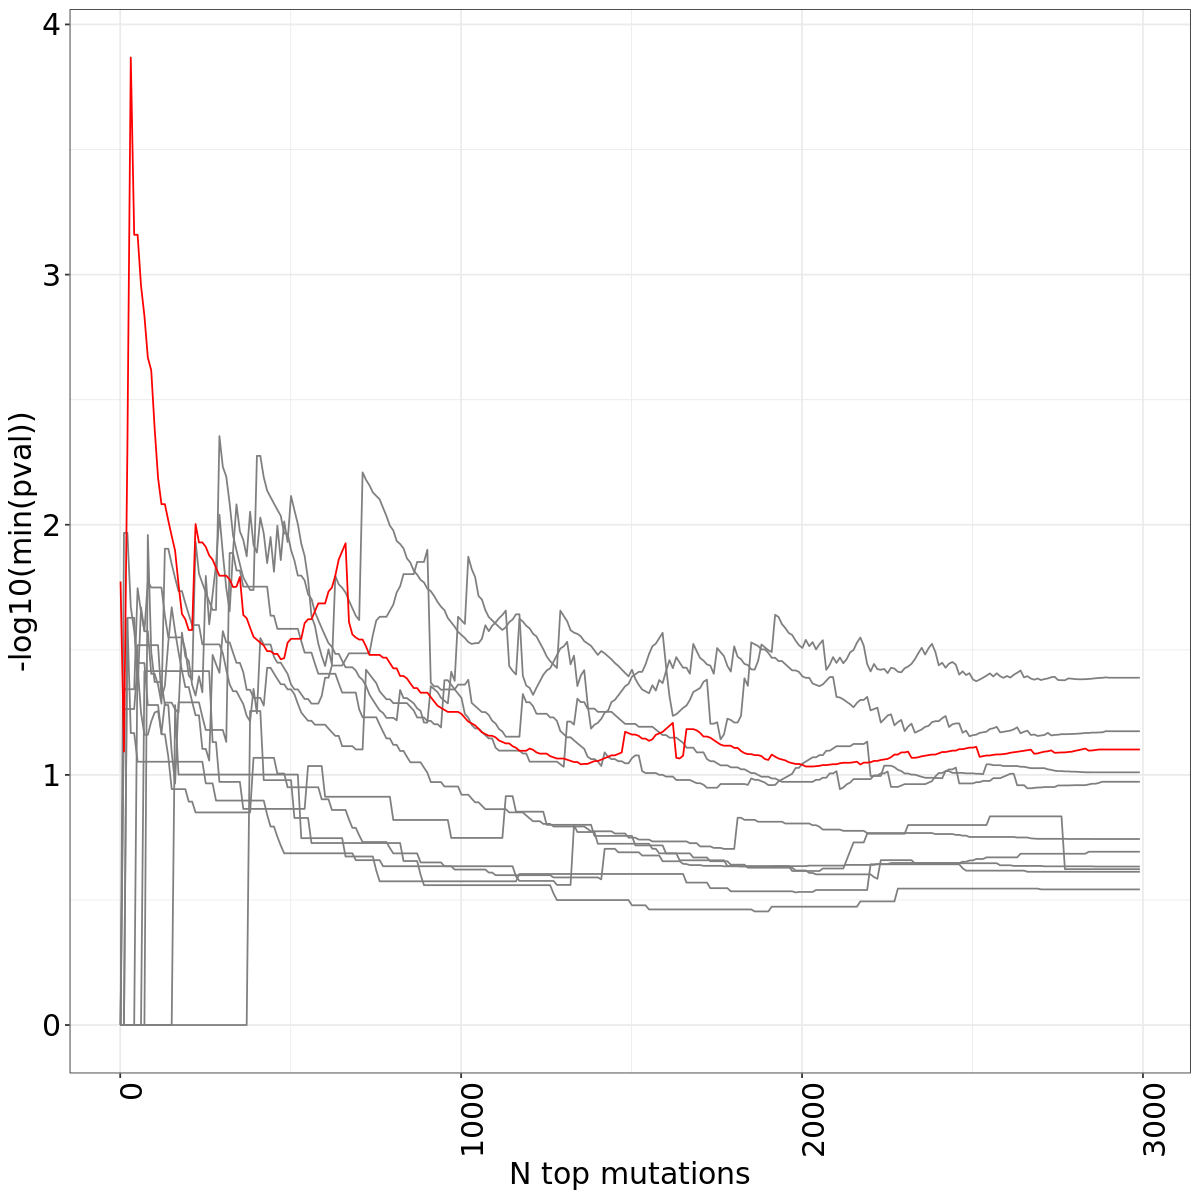

In [149]:
aggr.dataset %>% arrange(gene, desc(n)) %>% 
    ggplot(aes(x=n,y=-log10(most_sign_pval), color=gene)) + 
    geom_line() + 
    theme_bw() + 
    scale_color_manual(values=c(
        S='red',
        M='grey50',
        N='grey50',
        ORF9b='grey50',
        ORF1a='grey50',
        ORF1b='grey50',
        ORF3a='grey50',
        ORF7b='grey50',
        ORF7b='grey50',
        ORF8='grey50',
        ORF6='grey50',
        ORF10='grey50'
    )) +
    theme(axis.text.x = element_text(color='black', size=font_size, angle = 90, hjust=1), 
          axis.text.y = element_text(color='black', size=font_size), 
          axis.title.x = element_text(color='black', size=font_size), 
          axis.title.y = element_text(color='black', size=font_size),
          strip.text.x = element_text(color='black', size=font_size),
         legend.position = "none") +
    scale_x_continuous(name="N top mutations") + 
    scale_y_continuous(name="-log10(min(pval))") -> plot_per_gene_aggregate_sign

plot_per_gene_aggregate_sign

In [150]:
ggsave(paste0(output_plot_dir, 'plot_per_gene_aggregate_sign.png'), width=6, height=6, dpi=plot_dpi)